Projekt końcowy

Lending Club to firma pożyczkowa typu peer-to-peer, która łączy pożyczkobiorców z inwestorami za pośrednictwem platformy internetowej. Obsługuje osoby, które potrzebują pożyczek osobistych w wysokości od 1000 do 40 000 USD. Pożyczkobiorcy otrzymują pełną kwotę udzielonej pożyczki pomniejszoną o opłatę początkową, która jest uiszczana firmie. Inwestorzy kupują weksle zabezpieczone osobistymi pożyczkami i płacą Lending Club opłatę za usługę. Firma Lending Club udostępnia dane o wszystkich pożyczkach udzielonych za pośrednictwem swojej platformy w określonych okresach.
Na potrzeby tego projektu zostały użyte dane dotyczące pożyczek udzielonych za pośrednictwem Lending Club na przestrzeni lat 2007 -2011. Każda pożyczka jest opatrzona informacją o tym, czy ostatecznie została spłacona (Fully Paid lub Charged off w kolumnie loan_status). Twoim zadaniem jest zbudowanie modelu klasyfikacyjnego, który na podstawie tych danych będzie przewidywał z określoną dokładnością, czy potencjalny pożyczkobiorca spłaci swój dług z tytułu zaciągniętej pozyczki. Do zbioru danych dołączony jest plik z opisem wszystkich zmiennych oraz plik „FICO Score ranged.pdf”, w którym dokładnie opisano znaczenie jednej z kolumn.

Poniżej zaprezentowane są poszczególne etapy analizy, których wykonanie jest konieczne do zaliczenia projektu oraz ich punktacja:

- Obróbka danych (Data Processing) (70pkt) – jako doświadczony Data Scientist zapewne znasz poszczególne kroki, które należy wykonać na tym etapie, więc nie będziemy ich tutaj wyszczególniać.
- EDA, czyli obszerna eksploracja danych (100pkt) Opisz wnioski płynące z każdego wykresu, swoje hipotezy poprzyj testami statystycznymi takimi jak np. t-test lub Chi-square. Dodatkowo odpowiedz na poniższe pytania:
    - W jaki sposób wynik FICO wiąże się z prawdopodobieństwem spłacenia pożyczki przez pożyczkobiorcę?
    - W jaki sposób wiek kredytowy wiąże się z prawdopodobieństwem niewykonania zobowiązania i czy ryzyko to jest niezależne lub związane z wynikiem FICO
    - W jaki sposób status kredytu hipotecznego na dom wiąże się z prawdopodobieństwem niewypłacalności?
    - W jaki sposób roczny dochód wiąże się z prawdopodobieństwem niewykonania zobowiązania?
    - W jaki sposób historia zatrudnienia wiąże się z prawdopodobieństwem niewykonania zobowiązania?
    - Jak wielkość żądanej pożyczki jest powiązana z prawdopodobieństwem niewykonania zobowiązania?
- Feature Engineering – utwórz 20 nowych zmiennych (60 pkt)
- Modelowanie (150 pkt)
- Wykonaj klasteryzację danych (wypróbuj do tego celu kilka metod, min. 3) i sprawdź, czy występują jakieś segmenty pożyczkobiorców, wykorzystaj odpowiednie metody do określenia optymalnej liczby klastrów (40 pkt)
- Wytrenuj 5 różnych modeli, wykorzystując do każdego inny algorytm, a następnie porównaj ich działanie, za metrykę oceny jakości modelu przyjmij AUROC score. (50pkt)
- Sprawdź działanie wcześniej użytych metod na skompresowanych danych za pomocą PCA, porównaj wyniki (AUROC score) z modelami wytrenowanymi w poprzednim podpunkcie. (20pkt)
- Zbuduj finalny model, którego AUROC score będzie >= 80%, pamiętaj o doborze istotnych zmiennych, kroswalidacji oraz dostrojeniu parametrów modelu, pomyśl również o zbalansowaniu klas. (40pkt)

Za całość do zdobycia jest 380 punktów. Do zaliczenia projektu potrzeba minimum 300 pkt.
Powodzenia!

# Rozwiązanie

### Przygotowanie danych

Na początek importuję potrzebne biblioteki i globalne ustawienia. W trakcie pracy nad projektem, będę sukcesywnie dodawać kolejne potrzebne biblioteki.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from collections import Counter

# badania statystyczne
from scipy import stats
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score

# przygotowanie do uczenia maszynowego
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

# regresja logistyczna
from sklearn.linear_model import LogisticRegression
# drzewo decyzyjne
from sklearn.tree import DecisionTreeClassifier
# SVC
from sklearn.svm import SVC
# KNN
from sklearn.neighbors import KNeighborsClassifier

# złożone modele (ensemble learning)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
# !pip3 install lightgbm
import lightgbm as lgb
# !pip3 install xgboost
import xgboost as xgb

# algorytmy do klasteryzacji
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

In [2]:
# ustawiam wyświetlanie wykresów
%matplotlib inline
# ustawiam styl wykresów
sns.set_theme(style="whitegrid", palette="pastel")
# ustawiam stały random seed
np.random.seed(8416)

Ze względu na wielkość pliku, zmieniam wyświetlanie liczby kolumn oraz znaków w wierszu po to, żeby wyświetlały się wszystkie.

In [3]:
pd.set_option('max_columns', None)
pd.set_option("max_colwidth", None)

Wczytuję oba pliki. Plik z danymi do analizy nazywam "df", a z opisem kolumn "legend".

In [4]:
df = pd.read_csv("Loan_data.csv", delimiter=",", low_memory=False)
legend = pd.read_csv("LCDataDictionary.csv", delimiter=",")

Sprawdzam, czy zostały wczytane prawidłowo i jednocześnie zerkam, co się w nich znajduje.

In [5]:
legend.head()

,LoanStatNew,Description,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,acc_open_past_24mths,Number of trades opened in past 24 months.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,addr_state,The state provided by the borrower in the loan application,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,all_util,Balance to credit limit on all trades,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,annual_inc,The self-reported annual income provided by the borrower during registration.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print(df.shape)
df.head()

(42536, 151)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1077501,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1077501,Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,NaN,NaN,3.0,0.0,13648.0,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-2015,171.62,NaN,Aug-2018,739.0,735.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1077430,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br> Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college 

Zaczynam od wstępnego czyszczenia danych z niepotrzebnych kolumn. Na początek usuwam wszystkie kolumny bez danych oraz te, w których jest za dużo NaNów.

In [7]:
# na początek sprawdzam, jak dużo jest NaN w każdej kolumnie
nan_list = df.isna().sum().tolist()
print(nan_list)

[0, 42536, 1, 1, 1, 1, 1, 1, 1, 1, 2627, 1113, 1, 5, 1, 1, 1, 1, 1, 13294, 1, 14, 1, 1, 1, 30, 30, 1, 1, 30, 26927, 38885, 30, 30, 1, 91, 30, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 84, 1, 39787, 5, 1, 1, 146, 42536, 1, 1, 42536, 42536, 42536, 30, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 146, 30, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 1366, 106, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 1, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 42536, 1, 1, 42376, 42376, 42376, 42376, 42376, 42376]


In [8]:
# usuwam te kolumny, w których są tylko NaN
df = df.dropna(axis=1, how="all")

In [9]:
# ponownie sprawdzam, jak dużo jest NaN w każdej kolumnie
nan_list = df.isna().sum().tolist()
print(nan_list)

[0, 1, 1, 1, 1, 1, 1, 1, 1, 2627, 1113, 1, 5, 1, 1, 1, 1, 1, 13294, 1, 14, 1, 1, 1, 30, 30, 1, 1, 30, 26927, 38885, 30, 30, 1, 91, 30, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 84, 1, 39787, 5, 1, 1, 146, 1, 1, 30, 146, 30, 1366, 106, 1, 1, 1, 42376, 42376, 42376, 42376, 42376, 42376]


Widzę 2 rzeczy:
- po pierwsze w niemal każdej kolumnie poza ID znajdują się jakieś NaN, co wskazuje, że może być jakiś rząd, który mam puste wartości
- po drugie nadal znajdują się kolumny, które są w dużej mierze puste

In [10]:
# usuwam kolumny z dużą liczba pustych pól (więcej niż 20%)
df = df.dropna(axis=1, thresh=0.8*len(df))

In [11]:
# ponownie sprawdzam, jak dużo jest NaN w każdej kolumnie, tym razem chcę już też widzieć, jakich kolumn to dotyczy
nan_list = df.isna().sum()
print(nan_list)

id                               0
loan_amnt                        1
funded_amnt                      1
funded_amnt_inv                  1
term                             1
int_rate                         1
installment                      1
grade                            1
sub_grade                        1
emp_title                     2627
emp_length                    1113
home_ownership                   1
annual_inc                       5
verification_status              1
issue_d                          1
loan_status                      1
pymnt_plan                       1
url                              1
purpose                          1
title                           14
zip_code                         1
addr_state                       1
dti                              1
delinq_2yrs                     30
earliest_cr_line                30
fico_range_low                   1
fico_range_high                  1
inq_last_6mths                  30
open_acc            

In [12]:
# usuwam wiersze, które zawierają więcej niż 10 pustych pól 
df = df.dropna(axis=0, thresh=10)

In [13]:
# ponownie sprawdzam, jak dużo jest NaN w każdej kolumnie
nan_list = df.isna().sum()
print(nan_list)

id                               0
loan_amnt                        0
funded_amnt                      0
funded_amnt_inv                  0
term                             0
int_rate                         0
installment                      0
grade                            0
sub_grade                        0
emp_title                     2626
emp_length                    1112
home_ownership                   0
annual_inc                       4
verification_status              0
issue_d                          0
loan_status                      0
pymnt_plan                       0
url                              0
purpose                          0
title                           13
zip_code                         0
addr_state                       0
dti                              0
delinq_2yrs                     29
earliest_cr_line                29
fico_range_low                   0
fico_range_high                  0
inq_last_6mths                  29
open_acc            

In [14]:
# sprawdzam, jak wygląda aktualnie zbiór danych i widzę, że nadal składa się z 59 kolumn - czyli nadal za dużo do ML
print(df.shape)


(42535, 59)


In [15]:
# dodatkowo widzę, że mogę usunąć częśc wierszy, które zawierają puste wartości bez szkody dla zbioru
# ale żeby nie usuwać za dużo, chcę najpierw uzupełnić te, w których jest więcej niż ok. 100 pustych wartości

# wyświetlam tylko wiersze z NaN
df.isna().sum()[df.isna().sum()>0]

emp_title                     2626
emp_length                    1112
annual_inc                       4
title                           13
delinq_2yrs                     29
earliest_cr_line                29
inq_last_6mths                  29
open_acc                        29
pub_rec                         29
revol_util                      90
total_acc                       29
last_pymnt_d                    83
last_credit_pull_d               4
collections_12_mths_ex_med     145
acc_now_delinq                  29
chargeoff_within_12_mths       145
delinq_amnt                     29
pub_rec_bankruptcies          1365
tax_liens                      105
dtype: int64

In [16]:
# widzę, że do edycji pozostają mi dwie kolumny: emp_length, pub_rec_bankruptcies
# na początek chcę sprawdzić, jak wyglądają wartości w kolumnie emp_length
print("Ile jest unikalnych wartości:", df.emp_length.nunique())
print("Jakie to są dokładnie wartości:", df.emp_length.unique())

# zamieniam wartości kolumny na liczby
df.emp_length = df.emp_length.map({"< 1 year":0, "1 year":1, "2 years":2, "3 years":3, "4 years":4, "5 years":5, "6 years":6,
                  "7 years":7, "8 years":8, "9 years":9, "10+ years":10})

print("Średnia w kolumnie:", df.pub_rec_bankruptcies.mean())
# uzupełniam puste pola wartością średnią zaokrągloną do pełnej liczby
# zmieniam typ na INT w celu zmniejszenia zajmowanego miejsca bez strat dla danych, bo i tak są pełnymi liczbami
df.emp_length = df.emp_length.fillna(round(df.emp_length.mean())).astype("int32")

# patrzę, jak wyglądają aktualne wartości unikalne i czy na pewno nie ma już pustych pól
print("\nJak wygląda kolumna emp_length po uzupełnieniu pustych wartości:")
print("Ile jest unikalnych wartości:", df.emp_length.nunique())
print("Jakie to są dokładnie wartości:", df.emp_length.unique())
# już tutaj można zauważyć, że nie występuje na liście "nan", ale można to również sprawdzić w następujący sposób:
print("Czy są jeszcze puste pola:", df.emp_length.isna().sum())

Ile jest unikalnych wartości: 11
Jakie to są dokładnie wartości: ['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' nan]
Średnia w kolumnie: 0.04522710711683264

Jak wygląda kolumna emp_length po uzupełnieniu pustych wartości:
Ile jest unikalnych wartości: 11
Jakie to są dokładnie wartości: [10  0  1  3  8  9  4  5  6  2  7]
Czy są jeszcze puste pola: 0


In [17]:
# następnie tak samo sprawdzam kolumnę pub_rec_bankruptcies
print("Ile jest unikalnych wartości:", df.pub_rec_bankruptcies.nunique())
print("Jakie to są dokładnie wartości:", df.pub_rec_bankruptcies.unique())
print("Typ danych w kolumnie:", df.pub_rec_bankruptcies.dtypes)

print("Mediana w kolumnie:", df.pub_rec_bankruptcies.median())
print("Średnia w kolumnie:", df.pub_rec_bankruptcies.mean())

# w tej kolumnie również uzupełniam puste pola wartością średniej zaokrąglonej do pełnej liczy i zmieniam typ na INT
df.pub_rec_bankruptcies = df.pub_rec_bankruptcies.fillna(round(df.pub_rec_bankruptcies.mean())).astype("int32")
print("\nJak wygląda kolumna pub_rec_bankruptcies po uzupełnieniu pustych wartości:")

print("Ile jest unikalnych wartości:", df.pub_rec_bankruptcies.nunique())
print("Jakie to są dokładnie wartości:", df.pub_rec_bankruptcies.unique())
# już tutaj można zauważyć, że nie występuje na liście "nan", ale można to również sprawdzić w następujący sposób:
print("Czy są jeszcze puste pola:", df.emp_length.isna().sum())

Ile jest unikalnych wartości: 3
Jakie to są dokładnie wartości: [ 0.  1.  2. nan]
Typ danych w kolumnie: float64
Mediana w kolumnie: 0.0
Średnia w kolumnie: 0.04522710711683264

Jak wygląda kolumna pub_rec_bankruptcies po uzupełnieniu pustych wartości:
Ile jest unikalnych wartości: 3
Jakie to są dokładnie wartości: [0 1 2]
Czy są jeszcze puste pola: 0


In [18]:
# następnie usuwam wszystkie pozostałe wiersze, które zawierają puste pola i są to:
# annual_inc, title, delinq_2yrs, earliest_cr_line, inq_last_6mths, open_acc, pub_rec, revol_util,
# total_acc, tax_liens, last_credit_pull_d
df = df.dropna(axis=0)
print(df.shape)
df.isna().sum()

# widzę, że nadal mam dużo wierszy do analizy, bo prawie 40 000
# i jednocześnie już żadnych pustych pól, które utrudniałyby uczenie maszynowe

(39653, 59)


id                            0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_title                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
pymnt_plan                    0
url                           0
purpose                       0
title                         0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
fico_range_low                0
fico_range_high               0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_ut

Następnie przechodzę do dalszej analizy zawartości.
Na początek zamierzam usunąć dwa rodzaje kolumn: takie w których żadna wartość się nie powtarza oraz takie które zawierają tylko jedną wartość. Żadna z tych kolumn nie będzie przydatna przy uczeniu maszynowym.

In [19]:
# sprawdzam, ile unikalnych wartości znajduje się w każdej z kolumn
df.nunique()

id                            39653
loan_amnt                       886
funded_amnt                    1041
funded_amnt_inv                8785
term                              2
int_rate                        391
installment                   15732
grade                             7
sub_grade                        35
emp_title                     30463
emp_length                       11
home_ownership                    5
annual_inc                     5247
verification_status               3
issue_d                          53
loan_status                       4
pymnt_plan                        1
url                           39653
purpose                          14
title                         19831
zip_code                        831
addr_state                       50
dti                            2887
delinq_2yrs                      11
earliest_cr_line                514
fico_range_low                   44
fico_range_high                  44
inq_last_6mths              

In [20]:
# widzę, że kilka kolumn ma tylko 1 wartość, a w kilku wartości nie powtarzają się w ogóle lub prawie w ogóle, więc je usuwam
unique_values = df.nunique()
to_drop = unique_values[unique_values == 1].index
df = df.drop(to_drop, axis=1)
to_drop = unique_values[unique_values > 30000].index
df = df.drop(to_drop, axis=1)
unique_values = df.nunique()
# sprawdzam wielkość bazy danych oraz jakie kolumny zostały
print(df.shape)
print(unique_values)


(39653, 40)
loan_amnt                    886
funded_amnt                 1041
funded_amnt_inv             8785
term                           2
int_rate                     391
installment                15732
grade                          7
sub_grade                     35
emp_length                    11
home_ownership                 5
annual_inc                  5247
verification_status            3
issue_d                       53
loan_status                    4
purpose                       14
title                      19831
zip_code                     831
addr_state                    50
dti                         2887
delinq_2yrs                   11
earliest_cr_line             514
fico_range_low                44
fico_range_high               44
inq_last_6mths                27
open_acc                      44
pub_rec                        6
revol_bal                  21954
revol_util                  1109
total_acc                     81
total_rec_prncp             710

Kolejnym krokiem jest wstępna analiza samej zawartości kolumn - co oznacza, że muszę ustalić, które zawierają dane z przyszłości (czyli dane, do których nie ma dostępu przy podejmowaniu decyzji kredytowej). W tym celu tworzę tabelę "preview" z opisem kolumn, które pozostały w "df".

In [21]:
# w "legend" zmieniam nazwę pierwszej kolumny na "name" i wielkość liter w nazwie drugiej kolumny dla ułatwienia
# usuwam też wszystkie kolejne kolumny, które nie zawierają żadnych danych
legend = legend.rename(columns={"LoanStatNew":"name", "Description":"description"}).dropna(axis=1, how="all")

In [22]:
# tworzę "preview" poprzez stworzenie tabeli z nazw kolumn "df", zmieniam nazwę na "name", żeby zgadzała się z nazwą w "legend"
# po czym łączę to z "legend" w taki sposób, żeby pojawiły się tylko obecne 
preview = df.columns.to_frame().rename(columns={0:"name"}).merge(legend, on="name", how="left")
preview

,name,description
0,loan_amnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
1,funded_amnt,The total amount committed to that loan at that point in time.
2,funded_amnt_inv,The total amount committed by investors for that loan at that point in time.
3,term,The number of payments on the loan. Values are in months and can be either 36 or 60.
4,int_rate,Interest Rate on the loan
5,installment,The monthly payment owed by the borrower if the loan originates.
6,grade,LC assigned loan grade
7,sub_grade,LC assigned loan subgrade
8,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
9,home_ownership,"The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER"


In [23]:
# usuwam kolumny z danymi z przyszłości
df = df.drop(["total_rec_prncp", "total_rec_late_fee", "last_fico_range_high", "last_fico_range_low", "acc_now_delinq", 
         "collection_recovery_fee", "recoveries", "last_pymnt_d", "last_pymnt_d"], axis=1)
print(df.shape)
df.head()

(39653, 32)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,pub_rec_bankruptcies,debt_settlement_flag
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,0,RENT,30000.0,Source Verified,Dec-2011,Charged Off,car,bike,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,3.0,0.0,1687.0,9.4%,4.0,Oct-2016,0,N
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,10,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,other,personel,917xx,CA,20.00,0.0,Feb-1996,690.0,694.0,1.0,10.0,0.0,5598.0,21%,37.0,Apr-2016,0,N
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,1,RENT,80000.0,Source Verified,Dec-2011,Fully Paid,other,Personal,972xx,OR,17.94,0.0,Jan-1996,695.0,699.0,0.0,15.0,0.0,27783.0,53.9%,38.0,Apr-2018,0,N
5,5000.0,5000.0,5000.0,36 months,7.90%,156.46,A,A4,3,RENT,36000.0,Source Verified,Dec-2011,Fully Paid,wedding,My wedding loan I promise to pay back,852xx,AZ,11.20,0.0,Nov-2004,730.0,734.0,3.0,9.0,0.0,7963.0,28.3%,12.0,Feb-2017,0,N
6,7000.0,7000.0,7000.0,60 months,15.96%,170.08,C,C5,8,RENT,47004.0,Not Verified,Dec-2011,Fully Paid,debt_consolidation,Loan,280xx,NC,23.51,0.0,Jul-2005,690.0,694.0,1.0,7.0,0.0,17726.0,85.6%,11.0,Sep-2016,0,N


Po usunięciu danych chcę sprawdzić kolumny z kilkoma unikalnymi wartościami i sprawdzić, czy mogę je jakoś zmodyfikować, oraz chcę usunąć znaki specjalne lub inne niepotrzebne informacje. Upewnię się również, czy dane w kolumnach są odpowiedniego typu.

In [24]:
# term

# kolumna term opisuje, na jaki czas został przyznany kredyt i zwiera 2 wartości - 36 months i 60 months
print(df.term.unique())

[' 60 months' ' 36 months']


In [25]:
# term_months (z term)

# zmieniam dane w kolumnie na dane liczbowe, bez dodatkowej informacji o tym, że są to miesiące, za to w nazwie kolumny dodaję "months"
df = df.rename(columns={"term": "term_months"})
df.term_months = df.term_months.map({" 36 months":36, " 60 months":60}).astype("int32")

In [26]:
# int_rate

# usuwam "%" z kolumny "int_rate" i zmieniam typ na float
df.int_rate = df.int_rate.str.replace("%", "").astype(float)

In [27]:
# grade

print("Ile jest unikalnych wartości:", df.grade.nunique())
print("Jakie to są dokładnie wartości:", df.grade.sort_values().unique())

#zamieniam litery na cyfry
df.grade = df.grade.map({"A":1, "B":2, "C":3, "D":4, "E":5, "F":6, "G":7}).astype("int32")

print("Wartości po zmianie:", df.grade.sort_values().unique())

Ile jest unikalnych wartości: 7
Jakie to są dokładnie wartości: ['A' 'B' 'C' 'D' 'E' 'F' 'G']
Wartości po zmianie: [1 2 3 4 5 6 7]


In [28]:
# sub_grade

print("Ile jest unikalnych wartości:", df.sub_grade.nunique())
print("Jakie to są dokładnie wartości:", df.sub_grade.unique())

# widzę, że jest za dużo unikalnych wartości, żeby to aktualnie zmieniać - będę mógł to zrobić, jeśli okaże się to przydatne

Ile jest unikalnych wartości: 35
Jakie to są dokładnie wartości: ['C4' 'C1' 'B5' 'A4' 'C5' 'E1' 'C3' 'B1' 'B2' 'D1' 'A1' 'B3' 'B4' 'D2'
 'A5' 'A3' 'A2' 'E4' 'D3' 'C2' 'F2' 'D4' 'F3' 'E3' 'F4' 'F1' 'D5' 'E5'
 'G4' 'E2' 'G3' 'G2' 'G1' 'F5' 'G5']


In [29]:
# home_ownership

print("Ile jest unikalnych wartości:", df.home_ownership.nunique())
print("Jakie to są dokładnie wartości:", df.home_ownership.unique())
print("Jak często występują konkretne wartości:")
print(df.home_ownership.value_counts())

# ze względu na to, że wartości "NONE" są tylko dwie, to dla ułatwienia zmieniam je na "OTHER"
df.home_ownership = df.home_ownership.replace("NONE","OTHER")

# sprwdzam, czy wszystko się zgadza
print("Jak często występują konkretne wartości po zmianie:")
df.home_ownership.value_counts()

Ile jest unikalnych wartości: 5
Jakie to są dokładnie wartości: ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE']
Jak często występują konkretne wartości:
RENT        18988
MORTGAGE    17724
OWN          2809
OTHER         130
NONE            2
Name: home_ownership, dtype: int64
Jak często występują konkretne wartości po zmianie:


RENT        18988
MORTGAGE    17724
OWN          2809
OTHER         132
Name: home_ownership, dtype: int64

In [30]:
# revol_util

# usuwam % i zmieniam typ danych na float
df.revol_util = df.revol_util.str.replace("%", "").astype(float)

In [31]:
# debt_settlement_flag

print("Ile jest unikalnych wartości:", df.debt_settlement_flag.nunique())
print("Jakie to są dokładnie wartości:", df.debt_settlement_flag.unique())

# zmieniam oznaczenie z "N" na 0 i z "Y" na 1
df.debt_settlement_flag = df.debt_settlement_flag.map({"N":0, "Y":1}).astype("int32")

print("\nJakie są wartości po zmianie:", df.debt_settlement_flag.unique())

Ile jest unikalnych wartości: 2
Jakie to są dokładnie wartości: ['N' 'Y']

Jakie są wartości po zmianie: [0 1]


In [32]:
# issue_d

# zmieniam zapis słowny na zapis samej daty, z ograniczeniem do tylko roku i miesiąca, bo tylko te dane są zawarte w kolumnie
df.issue_d = pd.to_datetime(df.issue_d).dt.to_period("m")


In [33]:
# earliest_cr_line

# zmieniam zapis słowny na zapis samej daty, z ograniczeniem do tylko roku i miesiąca, bo tylko te dane są zawarte w kolumnie
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line).dt.to_period("m")


In [34]:
# loan_status

print("Ile jest unikalnych wartości:", df.loan_status.nunique())
print("Jakie to są dokładnie wartości:", df.loan_status.unique())

# zmieniam wartości w taki sposób, żeby zostały tylko "Fully Paid" i "Charged Off"
df.loan_status = df.loan_status.replace(["Does not meet the credit policy. Status:Fully Paid", "Does not meet the credit policy. Status:Charged Off"],
                                        ["Fully Paid", "Charged Off"])

print("\nJakie są wartości po zmianie:", df.loan_status.unique())

# następnie zmieniam wartości słowne na 1 i 0 (kolejno "Fully Paid" i "Charged Off")
df.loan_status = df.loan_status.map({"Fully Paid":1, "Charged Off":0}).astype("int32")

print("\nJakie są wartości po ostatecznej zmianie:", df.loan_status.unique())

Ile jest unikalnych wartości: 4
Jakie to są dokładnie wartości: ['Charged Off' 'Fully Paid'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off']

Jakie są wartości po zmianie: ['Charged Off' 'Fully Paid']

Jakie są wartości po ostatecznej zmianie: [0 1]


In [35]:
# zip_code

print("Ile jest unikalnych wartości:", df.zip_code.nunique())
print("Jakie to są dokładnie wartości:", df.zip_code.unique())

# widzę, że wszystkie wartości w kolumnie "zip_code" składają się z 3 cyfr i "xx", więc w celu ułatwienia usuwam "xx"

df.zip_code = df.zip_code.str.replace("xx", "")

# unikalnych wartości jest bardzo dużo, więc bardzo prawdopodobne, że i tak ta kolumna się nam nie przyda

Ile jest unikalnych wartości: 831
Jakie to są dokładnie wartości: ['309xx' '917xx' '972xx' '852xx' '280xx' '900xx' '774xx' '853xx' '913xx'
 '245xx' '606xx' '951xx' '641xx' '921xx' '067xx' '890xx' '770xx' '335xx'
 '799xx' '605xx' '150xx' '326xx' '564xx' '080xx' '330xx' '974xx' '934xx'
 '405xx' '946xx' '445xx' '850xx' '604xx' '292xx' '088xx' '029xx' '700xx'
 '010xx' '441xx' '104xx' '061xx' '616xx' '947xx' '914xx' '765xx' '980xx'
 '017xx' '752xx' '787xx' '077xx' '540xx' '225xx' '440xx' '437xx' '559xx'
 '912xx' '325xx' '300xx' '923xx' '352xx' '013xx' '146xx' '074xx' '786xx'
 '937xx' '331xx' '115xx' '191xx' '114xx' '908xx' '902xx' '992xx' '750xx'
 '950xx' '329xx' '226xx' '614xx' '802xx' '672xx' '083xx' '100xx' '926xx'
 '931xx' '860xx' '712xx' '707xx' '342xx' '895xx' '430xx' '919xx' '996xx'
 '891xx' '935xx' '801xx' '928xx' '233xx' '927xx' '970xx' '211xx' '303xx'
 '070xx' '194xx' '263xx' '403xx' '301xx' '553xx' '993xx' '312xx' '432xx'
 '602xx' '216xx' '151xx' '971xx' '305xx' '334xx' '050xx' '

In [36]:
# last_credit_pull_d

# zmieniam zapis słowny na zapis samej daty, z ograniczeniem do tylko roku i miesiąca, bo tylko te dane są zawarte w kolumnie
df.last_credit_pull_d = pd.to_datetime(df.last_credit_pull_d).dt.to_period("m")


In [37]:
# pub_rec

print("Unikalne wartości w kolumnie:", df.pub_rec.unique())

# spokojnie możemy zmienić typ kolumny na INT

df.pub_rec = df.pub_rec.astype("int32")

print("Unikalne wartości w kolumnie po zmianie:", df.pub_rec.unique())

Unikalne wartości w kolumnie: [0. 1. 2. 3. 4. 5.]
Unikalne wartości w kolumnie po zmianie: [0 1 2 3 4 5]


In [38]:
# sprawdzam, czy czegoś nie pominąłem
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term_months,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,pub_rec_bankruptcies,debt_settlement_flag
1,2500.0,2500.0,2500.0,60,15.27,59.83,3,C4,0,RENT,30000.0,Source Verified,2011-12,0,car,bike,309,GA,1.00,0.0,1999-04,740.0,744.0,5.0,3.0,0,1687.0,9.4,4.0,2016-10,0,0
3,10000.0,10000.0,10000.0,36,13.49,339.31,3,C1,10,RENT,49200.0,Source Verified,2011-12,1,other,personel,917,CA,20.00,0.0,1996-02,690.0,694.0,1.0,10.0,0,5598.0,21.0,37.0,2016-04,0,0
4,3000.0,3000.0,3000.0,60,12.69,67.79,2,B5,1,RENT,80000.0,Source Verified,2011-12,1,other,Personal,972,OR,17.94,0.0,1996-01,695.0,699.0,0.0,15.0,0,27783.0,53.9,38.0,2018-04,0,0
5,5000.0,5000.0,5000.0,36,7.90,156.46,1,A4,3,RENT,36000.0,Source Verified,2011-12,1,wedding,My wedding loan I promise to pay back,852,AZ,11.20,0.0,2004-11,730.0,734.0,3.0,9.0,0,7963.0,28.3,12.0,2017-02,0,0
6,7000.0,7000.0,7000.0,60,15.96,170.08,3,C5,8,RENT,47004.0,Not Verified,2011-12,1,debt_consolidation,Loan,280,NC,23.51,0.0,2005-07,690.0,694.0,1.0,7.0,0,17726.0,85.6,11.0,2016-09,0,0


In [39]:
# widzę, że mogę jeszcze zmienić typ w kolumnach delinq_2yrs, inq_last_6mths, open_acc, total_acc na INT

df[["delinq_2yrs", "inq_last_6mths", "open_acc", "total_acc"]] = df[["delinq_2yrs", "inq_last_6mths", "open_acc", "total_acc"]].astype("int32")

In [40]:
# sprawdzam typ danych w każdej kolumnie
df.dtypes

loan_amnt                 float64
funded_amnt               float64
funded_amnt_inv           float64
term_months                 int32
int_rate                  float64
installment               float64
grade                       int32
sub_grade                  object
emp_length                  int32
home_ownership             object
annual_inc                float64
verification_status        object
issue_d                 period[M]
loan_status                 int32
purpose                    object
title                      object
zip_code                   object
addr_state                 object
dti                       float64
delinq_2yrs                 int32
earliest_cr_line        period[M]
fico_range_low            float64
fico_range_high           float64
inq_last_6mths              int32
open_acc                    int32
pub_rec                     int32
revol_bal                 float64
revol_util                float64
total_acc                   int32
last_credit_pu





### Podstawowa analiza danych

Chcę lepiej poznać dane, więc na początek zwizualizuję na wykresach pojedyncze kolumny. Następnie będę szukał korelacji i innych związków między różnymi danymi.

<AxesSubplot:xlabel='funded_amnt', ylabel='funded_amnt_inv'>

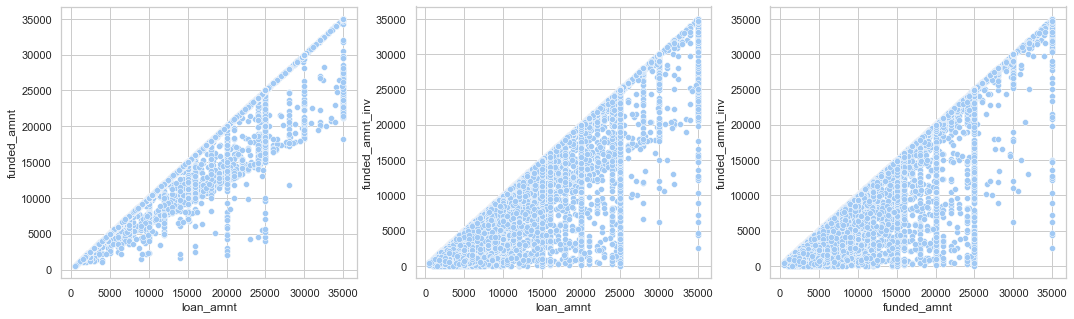

In [41]:
# loan_amnt, funded_amnt, funded_amnt_inv
# chcę sprawdzić, czy te wartości są sobie równe, czy nie

fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(18,5))

sns.scatterplot(x="loan_amnt", y="funded_amnt", data=df, ax=ax1)
sns.scatterplot(x="loan_amnt", y="funded_amnt_inv", data=df, ax=ax2)
sns.scatterplot(x="funded_amnt", y="funded_amnt_inv", data=df, ax=ax3)

# jak możemy zobaczyć wszystkie te wartości nie pokrywają się 1:1, czyli wszystkie 3 kolumny zawierają inne dane


Liczba poszczególnych wartości:
36    29228
60    10425
Name: term_months, dtype: int64


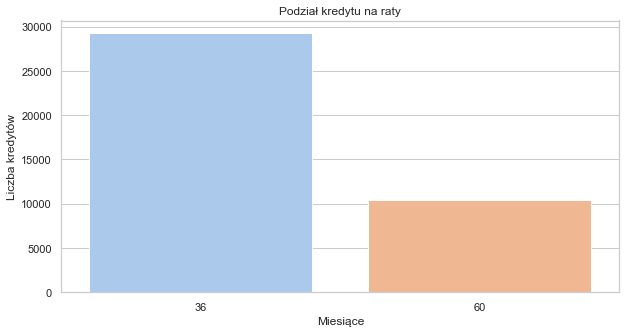

In [42]:
# wykres rozkładu term_months, na którym widzimy, że kredyty na 36 miesięcy były przyznawane niemal 3-krotnie częściej
plt.figure(figsize=(10,5))
sns.countplot(x="term_months", data=df).set(title="Podział kredytu na raty", xlabel="Miesiące", ylabel="Liczba kredytów")

print("\nLiczba poszczególnych wartości:")
print(df.term_months.value_counts())

Ile jest unikalnych wartości: 391
Typ danych w kolumnie: float64


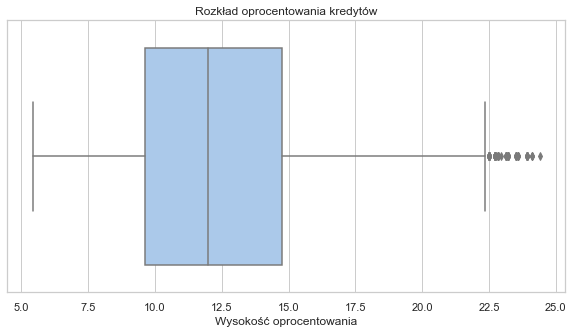

In [43]:
# wykres int_rate
plt.figure(figsize=(10,5))
sns.boxplot(x="int_rate", data=df).set(title="Rozkład oprocentowania kredytów", xlabel="Wysokość oprocentowania")

print("Ile jest unikalnych wartości:", df.int_rate.nunique())
print("Typ danych w kolumnie:", df.int_rate.dtypes)

# widzimy na nim, że oprocentowanie powyżej 22.5% to wartości odstające, które mnogą utrudniać naukę maszynową

Ile jest unikalnych wartości: 380
Typ danych w kolumnie: float64 

Poszczególne wartości:
count    39563.00
mean        12.17
std          3.67
min          5.42
25%          9.63
50%         11.99
75%         14.72
max         22.35
Name: int_rate, dtype: float64


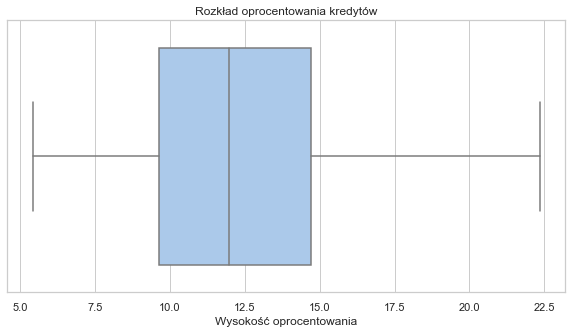

In [44]:
# usuwam wartości skrajne z tabeli
df = df.drop(df[df.int_rate>22.45].index, axis=0)

# ponownie drukuję wykres int_rate
plt.figure(figsize=(10,5))
sns.boxplot(x="int_rate", data=df).set(title="Rozkład oprocentowania kredytów", xlabel="Wysokość oprocentowania")

print("Ile jest unikalnych wartości:", df.int_rate.nunique())
print("Typ danych w kolumnie:", df.int_rate.dtypes, "\n")
print("Poszczególne wartości:")
print(round(df.int_rate.describe(), 2))

# na podstawie wykresu i funkcji describe() możemy wywnioskować, że:
# dane nie są symetryczne,
# średnia oprocentowania wynosi 12.17%,
# połowa kredytów była przyznawana z oprocentowaniem w wysokości 9,63%-14,72%,
# jest większa różnica w wysokości oprocentowania w 4. kwartylu niż w 1. kwartylu,
# czyli 25% kredytów z najniższy oprocentowaniem ma je mniej zróżnicowane niż 25% z najwyższym

Ile jest unikalnych wartości: 15671
Typ danych w kolumnie: float64 

Poszczególne wartości:
count    39563.000000
mean       323.720276
std        206.786152
min         15.670000
25%        167.670000
50%        280.260000
75%        429.165000
max       1305.190000
Name: installment, dtype: float64


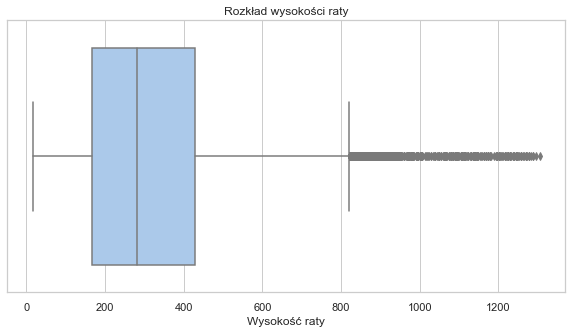

In [45]:
# installment

plt.figure(figsize=(10,5))
sns.boxplot(x="installment", data=df).set(title="Rozkład wysokości raty", xlabel="Wysokość raty")


print("Ile jest unikalnych wartości:", df.installment.nunique())
print("Typ danych w kolumnie:", df.installment.dtypes, "\n")
print("Poszczególne wartości:")
print(df.installment.describe())



Wcześniej klasy zostały zmienione według następującego klucza: A na 1, B na 2 itp.


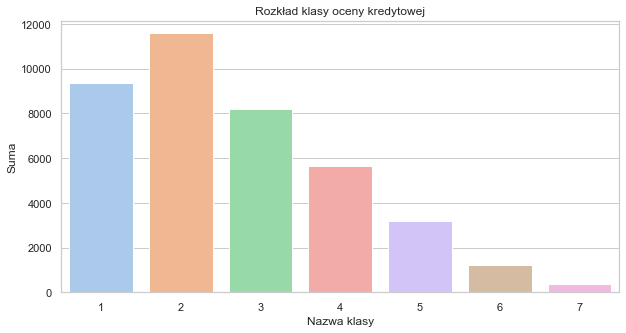

In [46]:
# grade
plt.figure(figsize=(10,5))
sns.countplot(x="grade", data=df).set(title="Rozkład klasy oceny kredytowej", xlabel="Nazwa klasy", ylabel="Suma")

print("Wcześniej klasy zostały zmienione według następującego klucza: A na 1, B na 2 itp.")

# na wykresie wyraźnie widzimy, że przeważają klienci z przyznaną klasą B, a zaraz za nimi są ci z klasą A i C
# widzimy również, że jest bardzo mało klientów z klasy G i niewiele więcej z F

[Text(0.5, 1.0, 'Rozkład długości zatrudnienia'),
 Text(0.5, 0, 'Długość zatrudnienia'),
 Text(0, 0.5, 'Suma')]

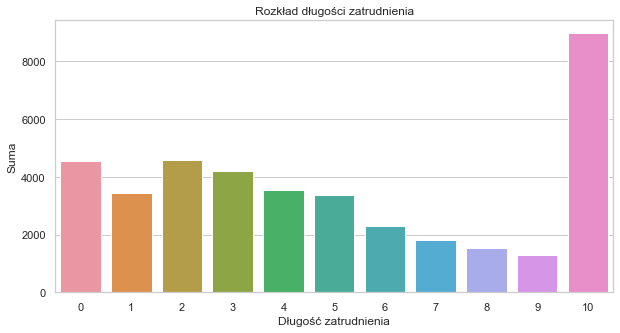

In [47]:
# emp_length

plt.figure(figsize=(10,5))
sns.countplot(x="emp_length", data=df).set(title="Rozkład długości zatrudnienia", xlabel="Długość zatrudnienia", ylabel="Suma")

# na tym wykresie widzimy, że rozkład jest w miarę zrównoważony, a jedynie znacznie wyższy jest słupek podpisany "10",
# w czym nie ma niczego dziwnego, skoro zostały w tej kategorii zgrupowane wszystkie osoby z 10 letnim i dłuższym stażem pracy


Liczba poszczególnych wartości:
RENT        18946
MORTGAGE    17682
OWN          2803
OTHER         132
Name: home_ownership, dtype: int64


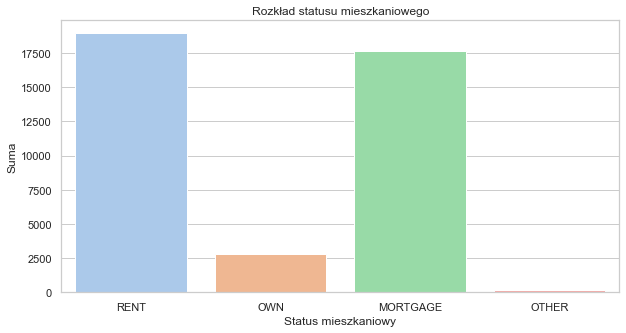

In [48]:
# home_ownership

plt.figure(figsize=(10,5))
sns.countplot(x="home_ownership", data=df).set(title="Rozkład statusu mieszkaniowego", xlabel="Status mieszkaniowy", ylabel="Suma")

print("\nLiczba poszczególnych wartości:")
print(df.home_ownership.value_counts())

# na wykresie wyraźnie widzimy, że ogromną większość stanowią mieszkania wynajmowane lub kupione na kredyt hipoteczny,
# tylko niewielką część stanowią mieszkania będące na własność klienta,
# a "OTHER" to tylko 132 wiersze - możliwe, że w dalszej analizie będzie warto usunąć te wiersze

Ile jest unikalnych wartości: 5244
count      39563.0
mean       69307.0
std        64096.0
min         1896.0
25%        41004.0
50%        60000.0
75%        82788.0
max      6000000.0
Name: annual_inc, dtype: float64


[Text(0.5, 1.0, 'Rozkład miesięcznych dochodów'),
 Text(0.5, 0, 'Miesięczny dochód')]

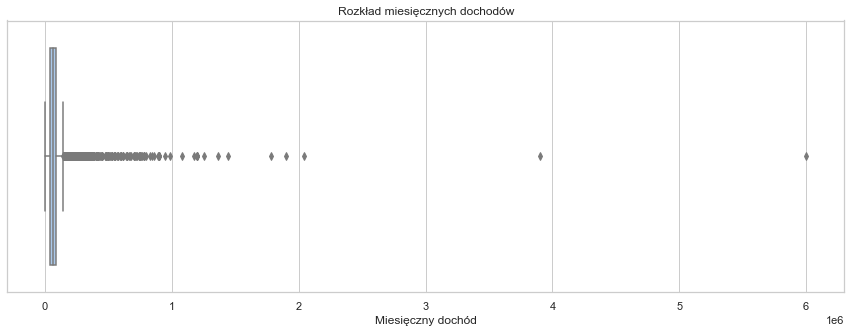

In [49]:
# annual_inc

print("Ile jest unikalnych wartości:", df.annual_inc.nunique())

# wiemy już, że wszystkie dane w tej kolumnie są liczbowe, więc użyjemy funkcji "describe", żeby dowiedzieć się więcej
# zaokrąglam do pełnych wartości, żeby uzyskać bardziej obrazowe dane (bez e+)
print(round(df.annual_inc.describe()))

plt.figure(figsize=(15,5))
sns.boxplot(x="annual_inc", data=df).set(title="Rozkład miesięcznych dochodów", xlabel="Miesięczny dochód")

# widzimy na wykresie, że mamy tak wysokie wartości skrajne, że nie pozwalają nam na zobrazowanie danych

count     39549.0
mean      68656.0
std       47757.0
min        1896.0
25%       41000.0
50%       60000.0
75%       82632.0
max      984000.0
Name: annual_inc, dtype: float64


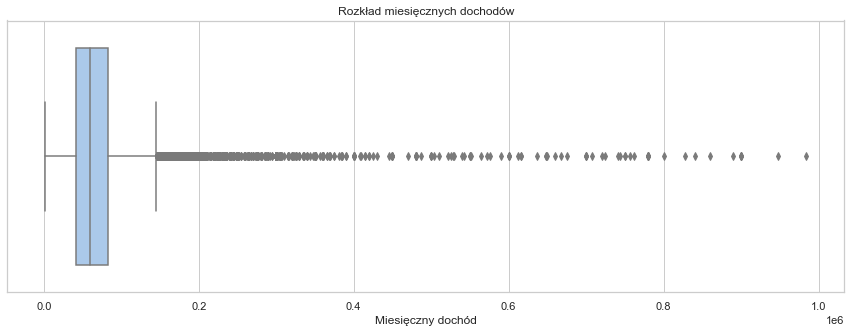

In [50]:
# usuwam wartości skrajne, czyli dochody powyżej 132 tyś. rocznie
df = df.drop(df[df.annual_inc>1000000].index, axis=0)

plt.figure(figsize=(15,5))
sns.boxplot(x="annual_inc", data=df).set(title="Rozkład miesięcznych dochodów", xlabel="Miesięczny dochód")

print(round(df.annual_inc.describe()))

# widzimy, że dzięki usunięciu wartości skrajnych mamy wprawdzie o ok. 2 tyś. mniej wierszy, ale dane są lepiej rozłożone,
# co pomoże nam zbudować dobry model


Liczba poszczególnych wartości:
Not Verified       17302
Verified           12503
Source Verified     9744
Name: verification_status, dtype: int64


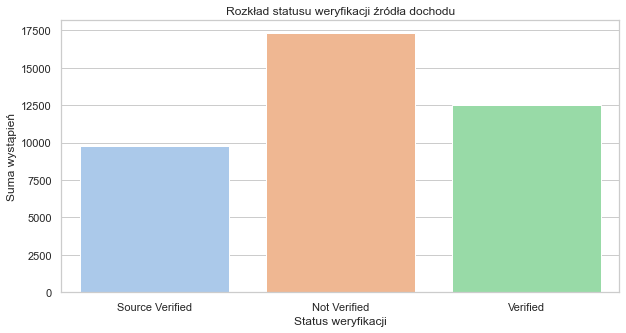

In [51]:
# verification_status

plt.figure(figsize=(10,5))
sns.countplot(x="verification_status", data=df).set(title="Rozkład statusu weryfikacji źródła dochodu", xlabel="Status weryfikacji", ylabel="Suma wystąpień")

print("\nLiczba poszczególnych wartości:")
print(df.verification_status.value_counts())

# na tym wykresie widzimy sporą przewagę niezweryfikowanych źródeł dochodu


Liczba poszczególnych wartości:
1    33807
0     5742
Name: loan_status, dtype: int64


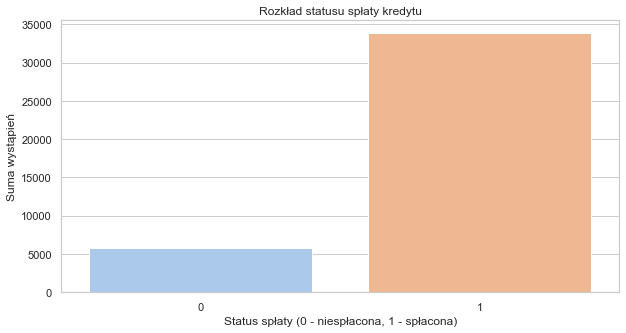

In [52]:
# loan_status

plt.figure(figsize=(10,5))
sns.countplot(x="loan_status", data=df).set(title="Rozkład statusu spłaty kredytu", xlabel="Status spłaty (0 - niespłacona, 1 - spłacona)", ylabel="Suma wystąpień")

print("\nLiczba poszczególnych wartości:")
print(df.loan_status.value_counts())

# tutaj widzimy, że niespłaconych kredytów jest znacznie mniej,
# co oznacza, że będziemy mieć do czynienia z niesymetrycznym zbiorem,
# który będziemy musieli zbalansować przed rozpoczęciem tworzenia modeli

Ile jest unikalnych wartości w kolumnie 'purpose': 14
Jakie to są dokładnie wartości: ['car' 'other' 'wedding' 'debt_consolidation' 'credit_card'
 'home_improvement' 'major_purchase' 'medical' 'moving' 'small_business'
 'vacation' 'house' 'renewable_energy' 'educational'] 

Ile jest unikalnych wartości 'title': 19801


[Text(0.5, 1.0, 'Rozkład celu kredytu'),
 Text(0.5, 0, 'Suma wystąpień'),
 Text(0, 0.5, 'Nazwa kategorii celu')]

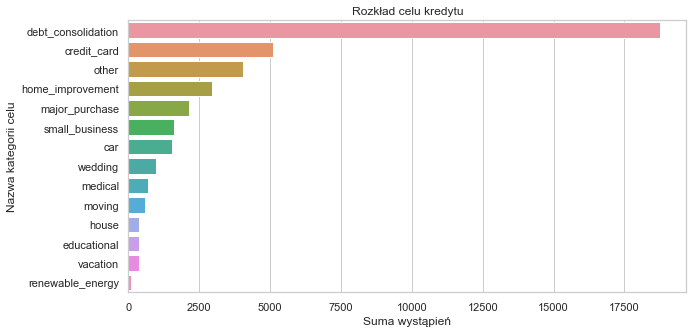

In [53]:
# purpose, title
print("Ile jest unikalnych wartości w kolumnie 'purpose':", df.purpose.nunique())
print("Jakie to są dokładnie wartości:", df.purpose.unique(), "\n")

print("Ile jest unikalnych wartości 'title':", df.title.nunique())

# widzimy, że w kolumnie "title", gdzie cel pożyczki był podawany przez klienta, mamy bardzo dużo unikalnych wartości,
# za to w kolumnie "purpose", która mówi o kategorii wydatku, jest ich tylko 14, co będziemy mogli wykorzystać
# kolumnę "title" jeszcze zostawiam, ale najprawdopodobniej zupełnie nam się nie przyda

plt.figure(figsize=(10,5))
sns.countplot(y="purpose", data=df, order=df.purpose.value_counts().index).set(title="Rozkład celu kredytu", xlabel="Suma wystąpień", ylabel="Nazwa kategorii celu")

# na wykresie widzimy, że wartości są bardzo zróżnicowane, mamy też sporą grupę wartości "inne"
# i najwięcej kredytów jest branych w celu konsolidacji, a najmniej na energię odnawialną 

Ile jest unikalnych wartości w kolumnie 'zip_code': 831
Ile jest unikalnych wartości w kolumnie 'addr_state': 50
Jakie to są dokładnie wartości: ['GA' 'CA' 'OR' 'AZ' 'NC' 'TX' 'VA' 'IL' 'MO' 'CT' 'UT' 'FL' 'PA' 'MN'
 'NJ' 'KY' 'OH' 'SC' 'RI' 'LA' 'MA' 'NY' 'WA' 'WI' 'AL' 'CO' 'KS' 'NV'
 'AK' 'MD' 'WV' 'VT' 'MI' 'DC' 'NH' 'AR' 'NM' 'MT' 'HI' 'WY' 'OK' 'SD'
 'DE' 'MS' 'TN' 'IA' 'NE' 'ID' 'IN' 'ME']


[Text(0.5, 1.0, 'Rozkład miejsca zamieszkania według stanu'),
 Text(0.5, 0, 'Suma'),
 Text(0, 0.5, 'Skrót stanu')]

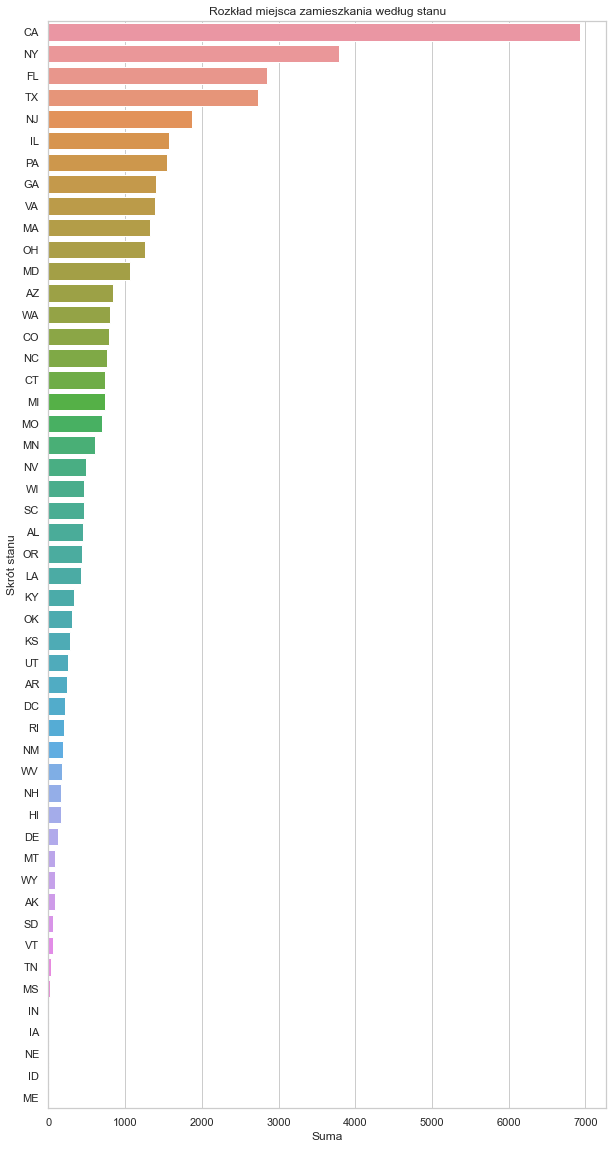

In [54]:
# zip_code, addr_state

print("Ile jest unikalnych wartości w kolumnie 'zip_code':", df.zip_code.nunique())

# w kolumnie "zip_code" znajduje się za dużo różnych wartości kategorycznych, żeby na jej podstawie analizować,
# więc sięgniemy po kolumnę "addr_state", która również dotyczy miejsca zamieszkania
print("Ile jest unikalnych wartości w kolumnie 'addr_state':", df.addr_state.nunique())
print("Jakie to są dokładnie wartości:", df.addr_state.unique())

plt.figure(figsize=(10,20))
sns.countplot(y="addr_state", data=df, order=df.addr_state.value_counts().index).set(title="Rozkład miejsca zamieszkania według stanu", xlabel="Suma", ylabel="Skrót stanu")

# na wykresie widzimy, że najwięcej kredytów udzielono w Kalifornii, a następnie w stanie Nowy York już prawie dwa razy mniej,
# za to najmniej kredytów (blisko 0) zostało udzielonych w stanach: Indiana, Iowa, Idaho, Nebraska, Maine

Ile jest unikalnych wartości w kolumnie 'dti': 2887
count    39549.00
mean        13.47
std          6.70
min          0.00
25%          8.34
50%         13.56
75%         18.75
max         29.99
Name: dti, dtype: float64


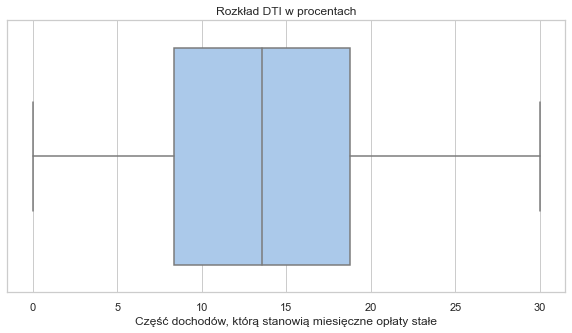

In [55]:
# dti - obliczane według wzoru: miesięczne zobowiązania/zadeklarowane miesięczne dochody (w procentach)

print("Ile jest unikalnych wartości w kolumnie 'dti':", df.dti.nunique())

plt.figure(figsize=(10,5))
sns.boxplot(x="dti", data=df).set(title="Rozkład DTI w procentach", xlabel="Część dochodów, którą stanowią miesięczne opłaty stałe")

print(round(df.dti.describe(), 2))

# widzimy, że wśród klientów_ek możemy spotkać osoby, które nie mają żadnych rat, a także takich, których opłaty stanowią 30% dochodów
# natomiast zbiór jest niemal symetryczny, co możemy wywnioskować nie tylko z kształtu wykresu,
# ale także tego, jak podobne są do siebie średnia (13,64) oraz mediana (13,8)

Ile jest unikalnych wartości w kolumnie: 11
Jakie to są dokładnie wartości: [ 0  1  2  3  4  5  6  7  8  9 11] 

0     35148
1      3345
2       715
3       225
4        65
5        26
6        13
7         6
8         3
11        2
9         1
Name: delinq_2yrs, dtype: int64


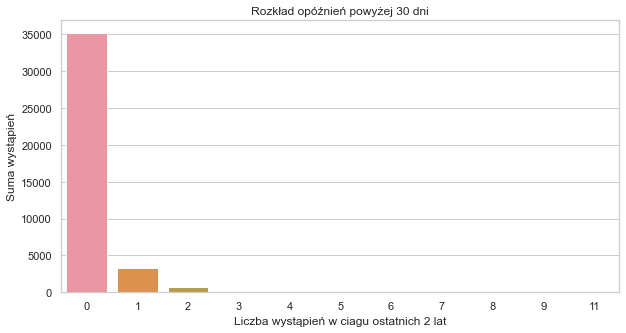

In [56]:
# delinq_2yrs 

print("Ile jest unikalnych wartości w kolumnie:", df.delinq_2yrs.nunique())
print("Jakie to są dokładnie wartości:", np.sort(df.delinq_2yrs.unique()), "\n")

plt.figure(figsize=(10,5))
sns.countplot(x="delinq_2yrs", data=df).set(title="Rozkład opóźnień powyżej 30 dni", xlabel="Liczba wystąpień w ciagu ostatnich 2 lat", ylabel="Suma wystąpień")

print(df.delinq_2yrs.value_counts())

# łatwo możemy zauważyć, że około 90% kredytobiorców nie miała opóźnienia w spłacie rat w ciągu ostatnich 2 lat,
# a tylko pojedyncze osoby zalegały z płatnościami więcej niż 5 razy

In [57]:
# fico_range_low, fico_range_high

print(df.fico_range_low.describe())
print(df.fico_range_high.describe())

# widzimy, że dane są bardzo podobne i nie miałoby sensu używać obu wartości w modelach,
# więc postanawiam wyliczyć średnią i utworzyć z niej nową kolumnę
df["fico_range"] = (df.fico_range_low + df.fico_range_high)/2

# następnie usuwam już niepotrzebne kolumny fico_range_low i fico_range_high
df = df.drop(["fico_range_low", "fico_range_high"], axis=1)

count    39549.000000
mean       712.646590
std         35.832222
min        610.000000
25%        685.000000
50%        710.000000
75%        735.000000
max        825.000000
Name: fico_range_low, dtype: float64
count    39549.000000
mean       716.646590
std         35.832222
min        614.000000
25%        689.000000
50%        714.000000
75%        739.000000
max        829.000000
Name: fico_range_high, dtype: float64


count    39549.000000
mean       714.646590
std         35.832222
min        612.000000
25%        687.000000
50%        712.000000
75%        737.000000
max        827.000000
Name: fico_range, dtype: float64


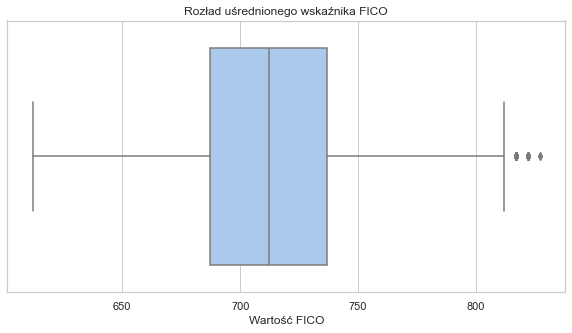

In [58]:
# fico_range

plt.figure(figsize=(10,5))
sns.boxplot(x="fico_range", data=df).set(title="Rozład uśrednionego wskaźnika FICO", xlabel="Wartość FICO")

print(df.fico_range.describe())

# na wykresie widzimy, że rozkład jest raczej symetryczny, ale mamy 3 wartości skrajne, które powinniśmy usunąć

[Text(0.5, 1.0, 'Rozład uśrednionego wskaźnika FICO'),
 Text(0.5, 0, 'Wartość FICO')]

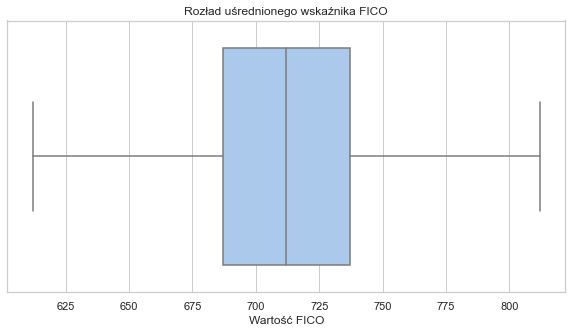

In [59]:
# usuwam wartości skrajne
df = df.drop(df[df.fico_range>815].index, axis=0)

# ponownie drukujemy wykres, na którym nie mamy już wartości skrajnych
plt.figure(figsize=(10,5))
sns.boxplot(x="fico_range", data=df).set(title="Rozład uśrednionego wskaźnika FICO", xlabel="Wartość FICO")

# 

Ile jest unikalnych wartości w kolumnie: 27


[Text(0.5, 1.0, 'Rozkład zapytań kredytowych (bez hipotecznych i na samochód) w ciągu ostatnich 6 miesięcy'),
 Text(0.5, 0, 'Suma wystąpień'),
 Text(0, 0.5, 'Liczba zapytań')]

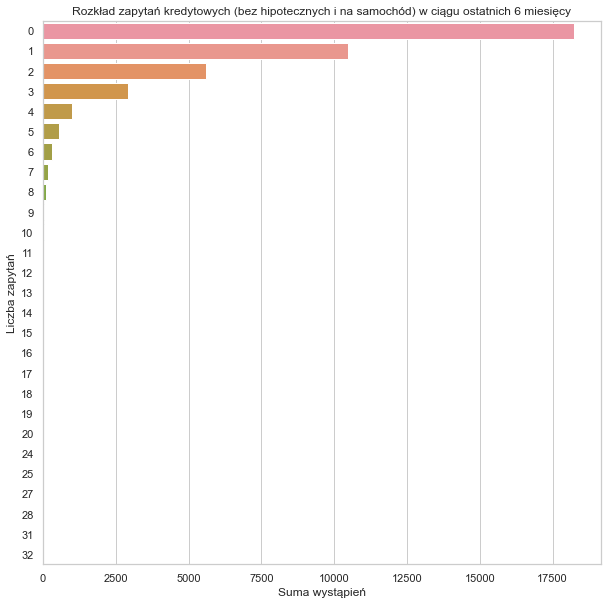

In [60]:
# inq_last_6mths

print("Ile jest unikalnych wartości w kolumnie:", df.inq_last_6mths.nunique())

plt.figure(figsize=(10,10))
sns.countplot(y="inq_last_6mths", data=df).set(title="Rozkład zapytań kredytowych (bez hipotecznych i na samochód) w ciągu ostatnich 6 miesięcy", xlabel="Suma wystąpień", ylabel="Liczba zapytań")

# widzimy, że około połowa osób nie występowała z wnioskiem o inny kredyt w ciągu 6 miesięcy poprzedzających ten wniosek,
# pojedyncze osoby występowały z takimi wnioskami więcej niż 5 razy, a reszta w większości 1 lub 2 razy

Ile jest unikalnych wartości w kolumnie: 44
count    39509.000000
mean         9.396644
std          4.476213
min          1.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         47.000000
Name: open_acc, dtype: float64


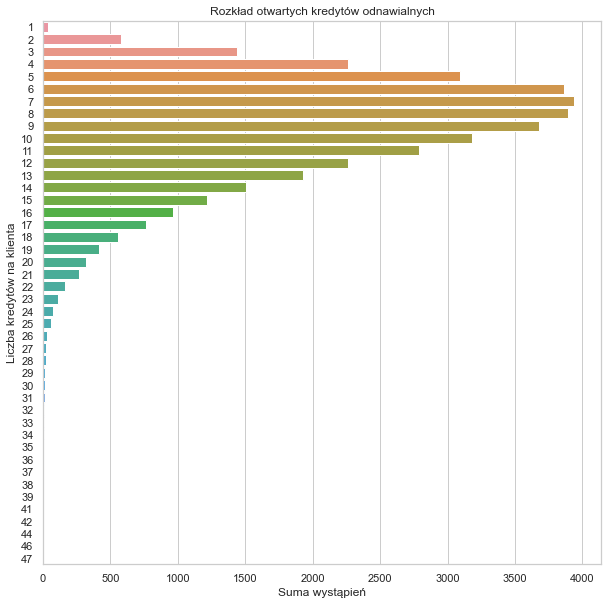

In [61]:
# open_acc

print("Ile jest unikalnych wartości w kolumnie:", df.open_acc.nunique())

plt.figure(figsize=(10,10))
sns.countplot(y="open_acc", data=df).set(title="Rozkład otwartych kredytów odnawialnych", xlabel="Suma wystąpień", ylabel="Liczba kredytów na klienta")

print(df.open_acc.describe())

# na wykresie widzimy, że kredyty odnawialne (inaczej linie kredytowe) są bardzo powszechne wśród klientów,
# ponieważ każdy klient posiadał co najmniej jeden, a większość posiadała 6-12 takich kredytów

Ile jest unikalnych wartości w kolumnie: 6
Jakie to są wartości: [0 1 2 3 4 5]
Jak często występują:
0    37368
1     2065
2       62
3       11
4        2
5        1
Name: pub_rec, dtype: int64


[Text(0.5, 1.0, 'Rozkład bankructwa i innych tego typu zdarzeń'),
 Text(0.5, 0, 'Liczba'),
 Text(0, 0.5, 'Suma wystąpień')]

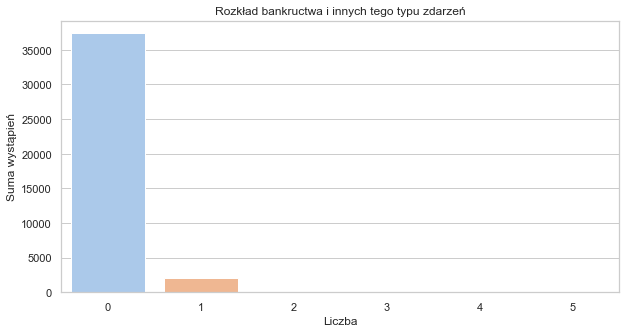

In [62]:
# pub_rec

print("Ile jest unikalnych wartości w kolumnie:", df.pub_rec.nunique())
print("Jakie to są wartości:", df.pub_rec.unique())
print("Jak często występują:")
print(df.pub_rec.value_counts())

plt.figure(figsize=(10,5))
sns.countplot(x="pub_rec", data=df).set(title="Rozkład bankructwa i innych tego typu zdarzeń", xlabel="Liczba", ylabel="Suma wystąpień")

# jak mogliśmy się spodziewać, w większości przypadków nie ma ogłoszonego bankructwa i innych tego typu zdarzeń,
# a wśród ogłoszonych w większości przypadków było ogłaszane jeden raz

Ile jest unikalnych wartości w kolumnie: 3
Jakie to są wartości: [0 1 2]
Jak często występują:
0    37850
1     1651
2        8
Name: pub_rec_bankruptcies, dtype: int64


[Text(0.5, 1.0, 'Rozkład bankructwa'),
 Text(0.5, 0, 'Liczba ogłoszonych bankructw'),
 Text(0, 0.5, 'Suma wystąpień')]

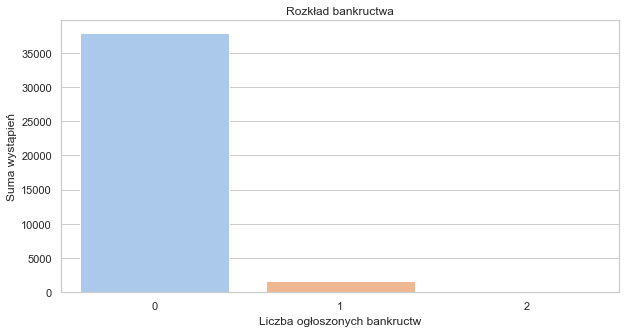

In [63]:
# pub_rec_bankruptcies

# ta kolumna pokazuje same bankructwa

print("Ile jest unikalnych wartości w kolumnie:", df.pub_rec_bankruptcies.nunique())
print("Jakie to są wartości:", df.pub_rec_bankruptcies.unique())
print("Jak często występują:")
print(df.pub_rec_bankruptcies.value_counts())

plt.figure(figsize=(10,5))
sns.countplot(x="pub_rec_bankruptcies", data=df).set(title="Rozkład bankructwa", xlabel="Liczba ogłoszonych bankructw", ylabel="Suma wystąpień")

# jak mogliśmy się spodziewać, bankructwa były ogłaszane tylko w niewielkiej części, a 2-krotne tylko w 7 przypadkach

Ile jest unikalnych wartości w kolumnie: 21902
count      39509.0
mean       14327.0
std        21724.0
min            0.0
25%         3757.0
50%         8986.0
75%        17394.0
max      1207359.0
Name: revol_bal, dtype: float64


[Text(0.5, 1.0, 'Rozkład sumy kredytów odnawialnych'),
 Text(0.5, 0, 'Wysokość kredytu')]

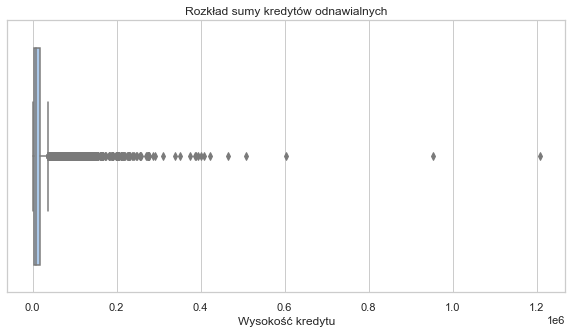

In [64]:
# revol_bal

print("Ile jest unikalnych wartości w kolumnie:", df.revol_bal.nunique())
print(round(df.revol_bal.describe()))

plt.figure(figsize=(10,5))
sns.boxplot(x="revol_bal", data=df).set(title="Rozkład sumy kredytów odnawialnych", xlabel="Wysokość kredytu")


Ile jest unikalnych wartości w kolumnie: 21808
count     39413.0
mean      13740.0
std       16703.0
min           0.0
25%        3745.0
50%        8956.0
75%       17295.0
max      152416.0
Name: revol_bal, dtype: float64


[Text(0.5, 1.0, 'Rozkład sumy kredytów odnawialnych'),
 Text(0.5, 0, 'Wysokość kredytu')]

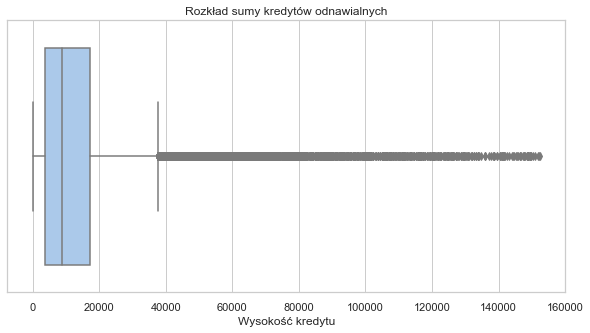

In [65]:
# revol_bal
# usuwam część wartości skrajnych
df = df.drop(df[df.revol_bal>155000].index, axis=0)

print("Ile jest unikalnych wartości w kolumnie:", df.revol_bal.nunique())
print(round(df.revol_bal.describe()))

plt.figure(figsize=(10,5))
sns.boxplot(x="revol_bal", data=df).set(title="Rozkład sumy kredytów odnawialnych", xlabel="Wysokość kredytu")

# nadal mamy dużo wartości skrajnych, ale ze względu na to, jak dużo ich jest, decyduję się ich nie usuwać,
# zwłaszcza że klienci z wyższym limitem odnawialnym również muszą być wzięci pod uwagę przy tworzeniu modelu

Ile jest unikalnych wartości w kolumnie: 1107
count    39413.0
mean        49.0
std         28.0
min          0.0
25%         26.0
50%         50.0
75%         73.0
max        119.0
Name: revol_util, dtype: float64


[Text(0.5, 1.0, 'Rozkład procentowego wykorzystania sumy kredytów odnawialnych'),
 Text(0.5, 0, 'Procent wykorzystania limitu kredytowego')]

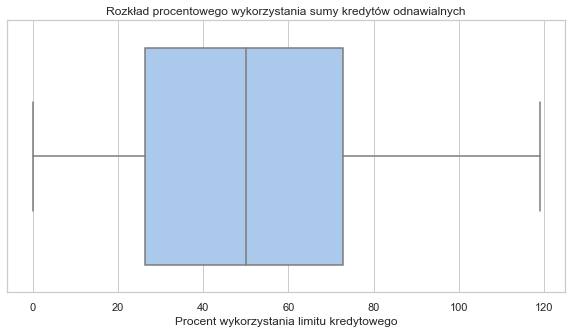

In [66]:
# revol_util


print("Ile jest unikalnych wartości w kolumnie:", df.revol_util.nunique())
print(round(df.revol_util.describe()))

plt.figure(figsize=(10,5))
sns.boxplot(x="revol_util", data=df).set(title="Rozkład procentowego wykorzystania sumy kredytów odnawialnych", xlabel="Procent wykorzystania limitu kredytowego")

# tutaj widzimy, że wykorzystanie limitów kredytowych waha się od 0% do nawet powyżej 100%

Ile jest unikalnych wartości w kolumnie: 81
count    39413.0
mean        22.0
std         12.0
min          1.0
25%         14.0
50%         21.0
75%         29.0
max         90.0
Name: total_acc, dtype: float64


[Text(0.5, 1.0, 'Rozkład sumy posiadanych linii kredytowych'),
 Text(0.5, 0, 'Suma')]

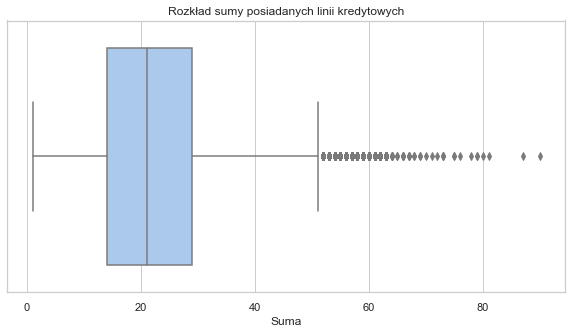

In [67]:
# total_acc

print("Ile jest unikalnych wartości w kolumnie:", df.total_acc.nunique())
print(round(df.total_acc.describe()))

plt.figure(figsize=(10,5))
sns.boxplot(x="total_acc", data=df).set(title="Rozkład sumy posiadanych linii kredytowych", xlabel="Suma")

# możemy zauważyć, że na wykresie znajduje się kilka wartości skrajnych, które znajdują się powyżej 50 linii kredytowych

Ile jest unikalnych wartości w kolumnie: 50
count    38564.0
mean        21.0
std         10.0
min          1.0
25%         13.0
50%         20.0
75%         28.0
max         50.0
Name: total_acc, dtype: float64


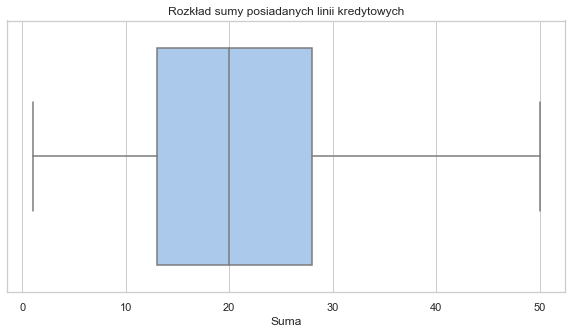

In [68]:
# total_acc
# usuwam wartości skrajne, ponieważ stanowią niewielki procent całego zbioru

df = df.drop(df[df.total_acc>50].index, axis=0)

plt.figure(figsize=(10,5))
sns.boxplot(x="total_acc", data=df).set(title="Rozkład sumy posiadanych linii kredytowych", xlabel="Suma")

print("Ile jest unikalnych wartości w kolumnie:", df.total_acc.nunique())
print(round(df.total_acc.describe()))

# teraz mamy ładny, niemal symetryczny zbiór przy utracie niewielkiej części danych

Ile jest unikalnych wartości w kolumnie: 2
Jakie to są wartości: [0 1]
Jak często występują:
0    38424
1      140
Name: debt_settlement_flag, dtype: int64


[Text(0.5, 1.0, 'Rozkład współpracy z firmami pomagającymi w spłacie kredytów'),
 Text(0.5, 0, 'Czy klient współpracuje (1 - tak, 0 nie)'),
 Text(0, 0.5, 'Suma wystąpień')]

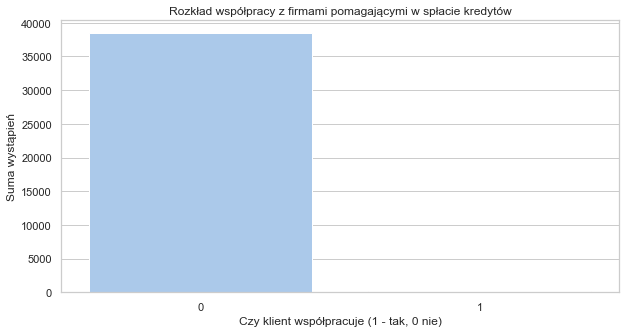

In [69]:
# debt_settlement_flag

print("Ile jest unikalnych wartości w kolumnie:", df.debt_settlement_flag.nunique())
print("Jakie to są wartości:", df.debt_settlement_flag.unique())
print("Jak często występują:")
print(df.debt_settlement_flag.value_counts())

plt.figure(figsize=(10,5))
sns.countplot(x="debt_settlement_flag", data=df).set(title="Rozkład współpracy z firmami pomagającymi w spłacie kredytów", xlabel="Czy klient współpracuje (1 - tak, 0 nie)", ylabel="Suma wystąpień")


### EDA - eksploracyjna analiza danych

Po przeanalizowaniu pojedynczych kolumn mam zamiar poszukać korelacji i różnych związków między różnymi kolumnami.

In [70]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term_months,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,pub_rec_bankruptcies,debt_settlement_flag,fico_range
1,2500.0,2500.0,2500.0,60,15.27,59.83,3,C4,0,RENT,30000.0,Source Verified,2011-12,0,car,bike,309,GA,1.00,0,1999-04,5,3,0,1687.0,9.4,4,2016-10,0,0,742.0
3,10000.0,10000.0,10000.0,36,13.49,339.31,3,C1,10,RENT,49200.0,Source Verified,2011-12,1,other,personel,917,CA,20.00,0,1996-02,1,10,0,5598.0,21.0,37,2016-04,0,0,692.0
4,3000.0,3000.0,3000.0,60,12.69,67.79,2,B5,1,RENT,80000.0,Source Verified,2011-12,1,other,Personal,972,OR,17.94,0,1996-01,0,15,0,27783.0,53.9,38,2018-04,0,0,697.0
5,5000.0,5000.0,5000.0,36,7.90,156.46,1,A4,3,RENT,36000.0,Source Verified,2011-12,1,wedding,My wedding loan I promise to pay back,852,AZ,11.20,0,2004-11,3,9,0,7963.0,28.3,12,2017-02,0,0,732.0
6,7000.0,7000.0,7000.0,60,15.96,170.08,3,C5,8,RENT,47004.0,Not Verified,2011-12,1,debt_consolidation,Loan,280,NC,23.51,0,2005-07,1,7,0,17726.0,85.6,11,2016-09,0,0,692.0


W jaki sposób wynik FICO wiąże się z prawdopodobieństwem spłacenia pożyczki przez pożyczkobiorcę?


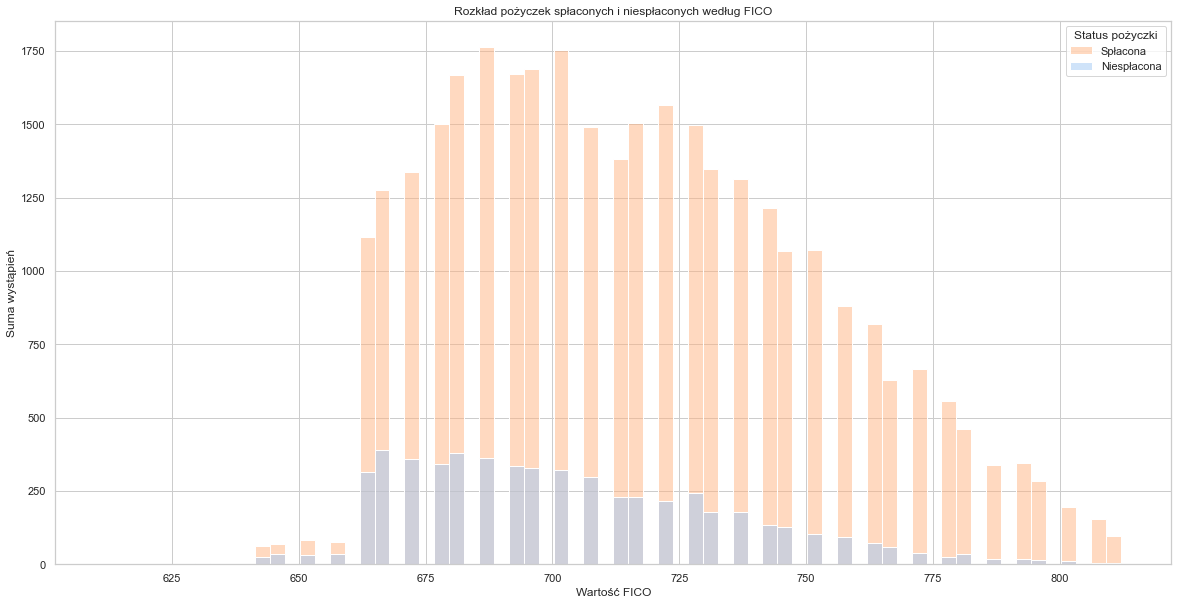

In [71]:
# rysuję wykres z podziałem na pożyczki spłacone i niespłacone

plt.figure(figsize=(20,10))
sns.histplot(x="fico_range", hue="loan_status", data=df).set(title="Rozkład pożyczek spłaconych i niespłaconych według FICO", xlabel="Wartość FICO", ylabel="Suma wystąpień")
plt.legend(labels=["Spłacona", "Niespłacona"], title="Status pożyczki")

# widzimy, że rozkład nie jest równy, przez co ciężko będzie nam zauważyć, jak dokładnie wygląda ta proporcja,
# ale możemy na pewno zauważyć, że jest bardzo mało klientów o wartości FICO poniżej ok. 660

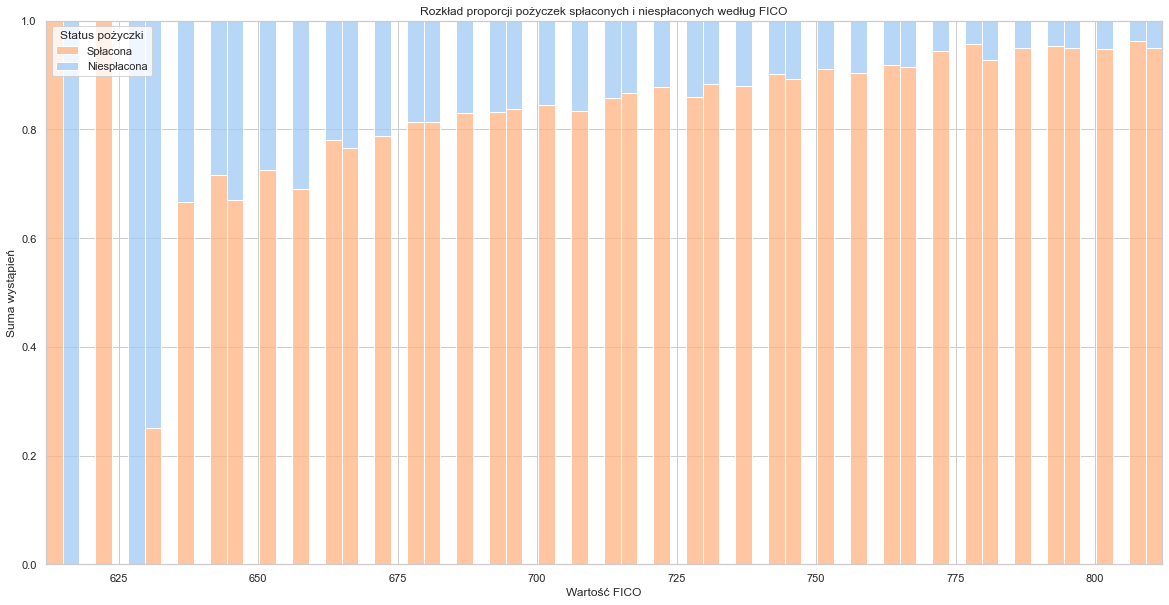

In [72]:
# używam argumentu multiple="fill", żeby wyraźniej pokazać proporcje między spłaconymi i niespłaconymi pożyczkami

plt.figure(figsize=(20,10))
sns.histplot(x="fico_range", hue="loan_status", data=df, multiple="fill").set(title="Rozkład proporcji pożyczek spłaconych i niespłaconych według FICO", xlabel="Wartość FICO", ylabel="Suma wystąpień")
plt.legend(labels=["Spłacona", "Niespłacona"], title="Status pożyczki")

# widzimy, że im wyższa wartość FICO, tym częstsze spłacanie pożyczek,
# natomiast im niższa wartość FICO, tym większe prawdopodobieństwo niespłacenia pożyczki,
# jednocześnie pamiętamy, że proporcje poniżej ok. 660 mogą być zaburzone ze względu na małą liczbę danych


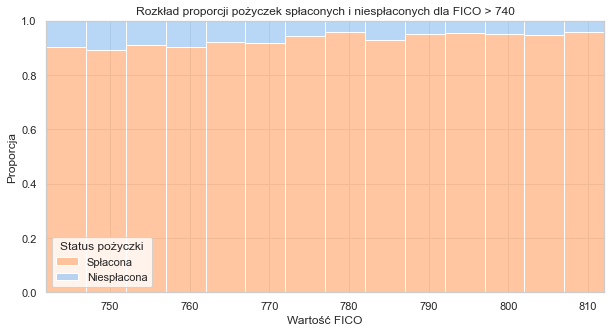

In [73]:
# osobno sprawdzam wartości powyżej 740, żeby znaleźć dokładniejsze miejsce, w którym maleje odsetek niespłaconych pożyczek

plt.figure(figsize=(10,5))
sns.histplot(x="fico_range", hue="loan_status", data=df[df["fico_range"]>740], multiple="fill", binwidth=5).set(title="Rozkład proporcji pożyczek spłaconych i niespłaconych dla FICO > 740", xlabel="Wartość FICO", ylabel="Proporcja")
plt.legend(labels=["Spłacona", "Niespłacona"], title="Status pożyczki")

# na podstawie tego wykresu możemy uznać, że wartość FICO równe lub powyżej 770 daje bardzo wysokie prawdopodobieństwo spłaty pożyczki

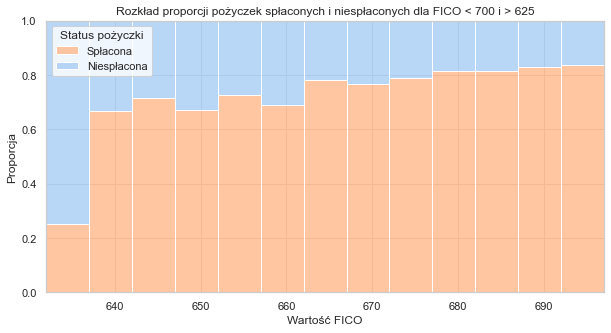

In [74]:
# teraz sprawdzam wartości poniżej 700, żeby znaleźć dokładniejsze miejsce, w którym wzrasta odsetek niespłaconych pożyczek
# odfiltrowuję też FICO < 625 ze względu na to, że występują tam tylko pojedyncze wartości, które zaburzają tendencję

plt.figure(figsize=(10,5))
sns.histplot(x="fico_range", hue="loan_status", data=df[(df["fico_range"]<700) & (df["fico_range"]>630)], multiple="fill", binwidth=5).set(title="Rozkład proporcji pożyczek spłaconych i niespłaconych dla FICO < 700 i > 625", xlabel="Wartość FICO", ylabel="Proporcja")
plt.legend(labels=["Spłacona", "Niespłacona"], title="Status pożyczki")

# na podstawie tego wykresu możemy uznać, że wartość FICO równe lub poniżej 660 oznacza znaczne prawdopodobieństwo braku spłaty pożyczki

W jaki sposób wiek kredytowy wiąże się z prawdopodobieństwem niewykonania zobowiązania i czy ryzyko to jest niezależne lub związane z wynikiem FICO?

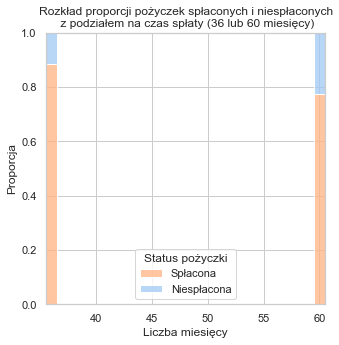

In [75]:
# tutaj zbadam, czy występuje zależność między kolumnami loan_status, term_months i fico_range

# najpierw porównuję status spłaty pożyczki z tym, na ile miesięcy była przyznana
plt.figure(figsize=(5,5))
sns.histplot(x="term_months", hue="loan_status", data=df, multiple="fill", discrete=True).set(title="Rozkład proporcji pożyczek spłaconych i niespłaconych\n z podziałem na czas spłaty (36 lub 60 miesięcy)", xlabel="Liczba miesięcy", ylabel="Proporcja")
plt.legend(labels=["Spłacona", "Niespłacona"], title="Status pożyczki")

# możemy zauważyć, że pożyczki udzielane na 60 miesięcy są częściej niespłacane w porównaniu z tymi na 36 miesięcy

[Text(0.5, 1.0, 'Rozkład statusu spłaty pożyczki w stosunku do FICO z podziałem na czas spłaty\n(bez uwzględnienia różnicy w wielkości zbiorów)'),
 Text(0.5, 0, 'Status pożyczki (0 - niespłacona, 1 - spłacona)'),
 Text(0, 0.5, 'FICO')]

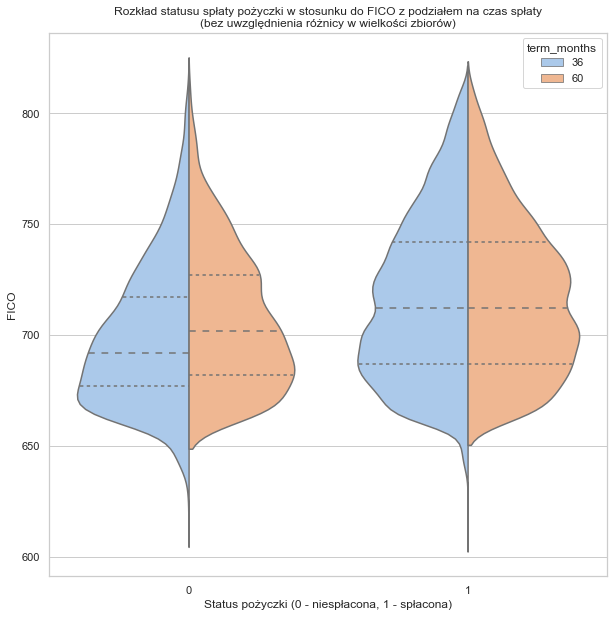

In [76]:
# na wykresie skrzypcowym chcę porównać status spłaty w stosunku do FICO z podziałem na długość kredytu

plt.figure(figsize=(10,10))

sns.violinplot(y="fico_range", x="loan_status", hue="term_months", data=df, inner="quartile", split=True).set(title="Rozkład statusu spłaty pożyczki w stosunku do FICO z podziałem na czas spłaty\n(bez uwzględnienia różnicy w wielkości zbiorów)", xlabel="Status pożyczki (0 - niespłacona, 1 - spłacona)", ylabel="FICO")

# na tych wykresach widzimy wyraźnie, że w przypadku spłaty FICO  nie ma żadnego wpływu, ponieważ kwantyle i mediana występują w tych samych miejscach
# natomiast w przypadku niespłaconych kredytów FICO jest niższe przy kredytach na 36 mmiesięcy, co widać po niższym usytuowaniu kwantyli i mediany

W jaki sposób status kredytu hipotecznego na dom wiąże się z prawdopodobieństwem niewypłacalności?

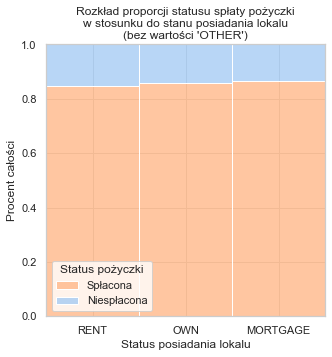

In [77]:
# tutaj zbadam, czy występuje zależność między kolumnami loan_status i występowaniem "mortgage" w kolumnie home_ownership

# tworzę wykres pokazujący proporcje między spłaconymi i niespłaconymi pożyczkami w zależności od statusu posiadania mieszkania,
# pomijam wartość "OTHER", ponieważ jest znacznie mniej takich wartości w bazie danych oraz nie wiemy, co oznacza

plt.figure(figsize=(5,5))
sns.histplot(x="home_ownership", hue="loan_status", data=df[df["home_ownership"]!="OTHER"], multiple="fill").set(title="Rozkład proporcji statusu spłaty pożyczki\nw stosunku do stanu posiadania lokalu\n(bez wartości 'OTHER')", xlabel="Status posiadania lokalu", ylabel="Procent całości")
plt.legend(labels=["Spłacona", "Niespłacona"], title="Status pożyczki")

# widzimy, że wynajmowanie mieszkania było skorelowane z najczęstszym niespłacaniem pożyczek,
# a posiadanie kredytu hipotecznego było skorelowane z najczęstszym spłacaniem pożyczki,
# ale te różnice są minimalne, na poziomie około 2-4 punktów procentowych

W jaki sposób roczny dochód wiąże się z prawdopodobieństwem niewykonania zobowiązania?

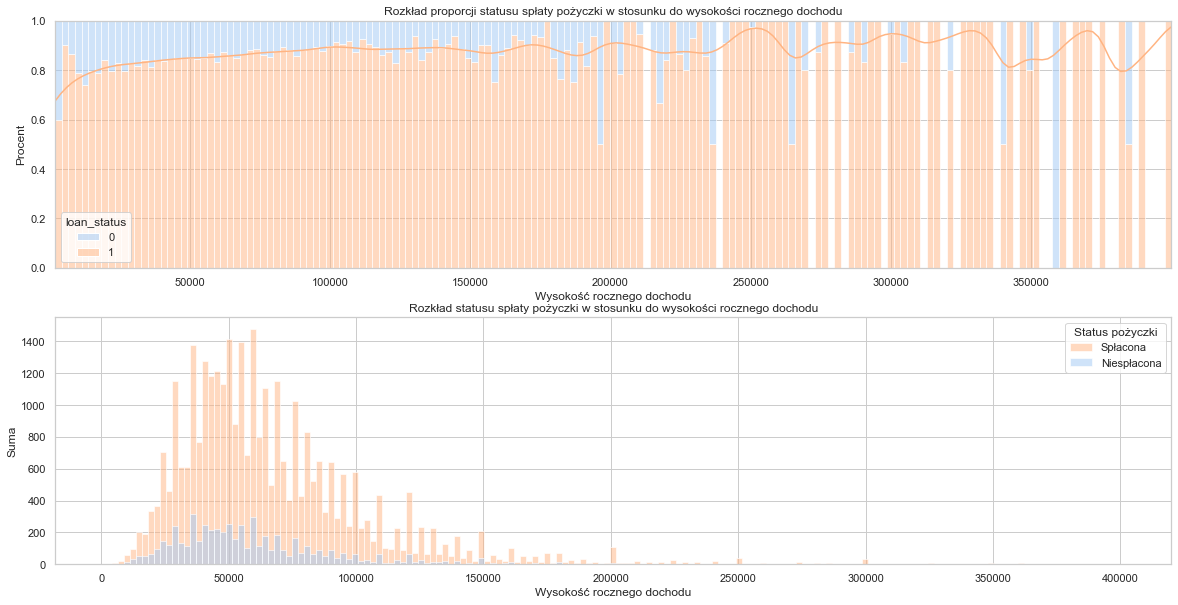

In [78]:
# tutaj zbadam, czy występuje zależność między kolumnami loan_status i wysokością rocznego dochodu z kolumny annual_inc

# dzielę przestrzeń pod dwa wykresy
fig,(ax1,ax2) = plt.subplots(2, 1, figsize=(20,10))

# ten wykres przedstawia proporcje między spłaconymi i niespłaconymi pożyczkami w stosunku do rocznego dochodu
# plus zmniejszam obszar badania do 400 000, ponieważ powyżej tej kwoty pojawiają jedynie pojedyncze rekordy
sns.histplot(x="annual_inc", hue="loan_status", data=df[df["annual_inc"]<400000], multiple="fill", kde=True, ax=ax1).set(title="Rozkład proporcji statusu spłaty pożyczki w stosunku do wysokości rocznego dochodu", xlabel="Wysokość rocznego dochodu", ylabel="Procent")
plt.legend(labels=["Spłacona", "Niespłacona"], title="Status pożyczki")

# a ten pokazuje, ile jest rekordów z danym dochodem
sns.histplot(x="annual_inc", hue="loan_status", data=df[df["annual_inc"]<400000], ax=ax2).set(title="Rozkład statusu spłaty pożyczki w stosunku do wysokości rocznego dochodu", xlabel="Wysokość rocznego dochodu", ylabel="Suma")
plt.legend(labels=["Spłacona", "Niespłacona"], title="Status pożyczki")

# jak widzimy przy wartościach powyżej ok. 200 000 następuje duża zmienność ze względu na niewiele rekordów
# osobiście nie widzę większej zależności, ale chcę się jeszcze upewnić, więc stworzę wykresy z bardziej ograniczonych danych,
# czyli z użyciem tej części, gdzie występuje dużo rekordów do porównania

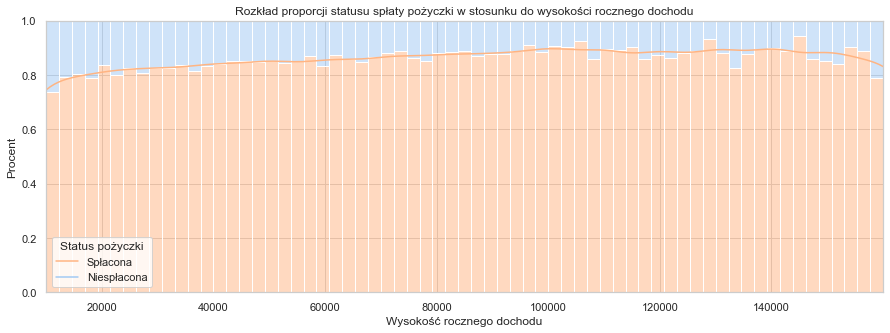

In [79]:
# ograniczam zakres do wartości pomiędzy 10 000 a 160 000

plt.figure(figsize=(15,5))
sns.histplot(x="annual_inc", hue="loan_status", data=df[((df["annual_inc"]>10000) & (df["annual_inc"]<160000))], multiple="fill", kde=True).set(title="Rozkład proporcji statusu spłaty pożyczki w stosunku do wysokości rocznego dochodu", xlabel="Wysokość rocznego dochodu", ylabel="Procent")
plt.legend(labels=["Spłacona", "Niespłacona"], title="Status pożyczki")

# tutaj możemy zauważyć, że faktycznie istnieje niewielka zależność między wysokością rocznego dochodu a brakiem spłaty pożyczki,
# przy czym większą różnicę możemy zauważyć przy bardzo niskim dochodzie, gdzie prawdopodobieństwo spłaty maleje,
# a przy dochodzie między ok. 60 000 - 140 000 to prawdopodobieństwo jest w miarę stałe

Jak wielkość żądanej pożyczki jest powiązana z prawdopodobieństwem niewykonania zobowiązania?

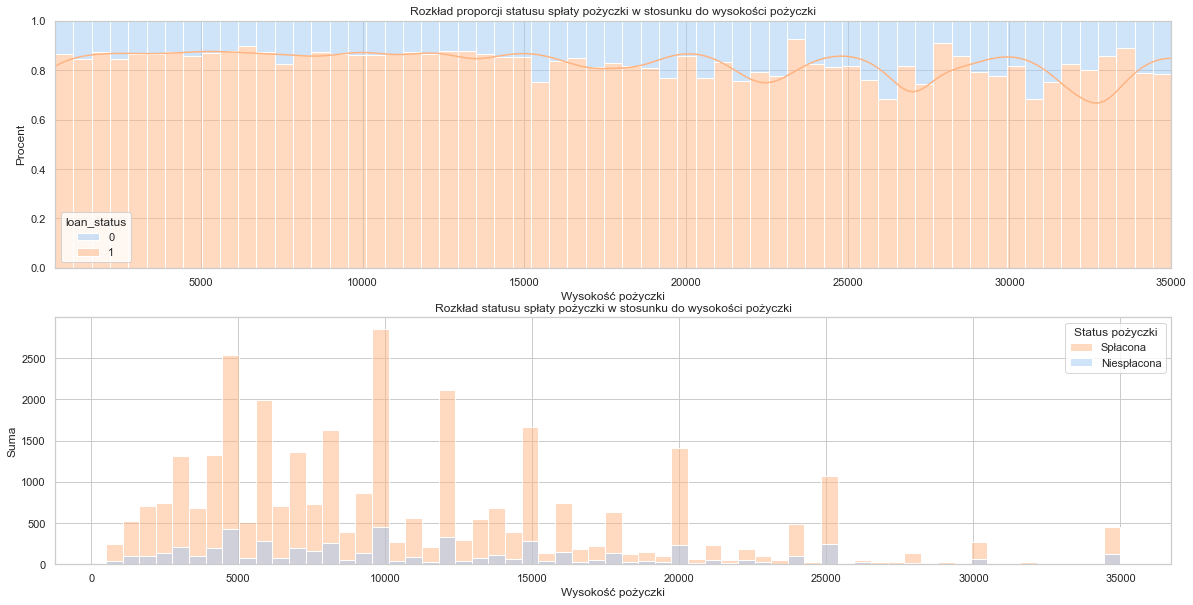

In [80]:
# tutaj zbadam, czy występuje zależność między kolumnami loan_status i wartością pożyczki z kolumny loan_amnt

# dzielę przestrzeń pod dwa wykresy
fig,(ax1,ax2) = plt.subplots(2, 1, figsize=(20,10))

# ten wykres przedstawia proporcje między spłaconymi i niespłaconymi pożyczkami w stosunku do wysokości pożyczki
sns.histplot(x="loan_amnt", hue="loan_status", data=df, multiple="fill", kde=True, ax=ax1).set(title="Rozkład proporcji statusu spłaty pożyczki w stosunku do wysokości pożyczki", xlabel="Wysokość pożyczki", ylabel="Procent")
plt.legend(labels=["Spłacona", "Niespłacona"], title="Status pożyczki")

# a ten pokazuje, ile jest rekordów z daną wysokością pożyczki
sns.histplot(x="loan_amnt", hue="loan_status", data=df, ax=ax2).set(title="Rozkład statusu spłaty pożyczki w stosunku do wysokości pożyczki", xlabel="Wysokość pożyczki", ylabel="Suma")
plt.legend(labels=["Spłacona", "Niespłacona"], title="Status pożyczki")

# tak samo jak w poprzednim przypadku pojawia się kłopot z określeniem trendu ze względu na różną liczebność rekordów z danymi wysokościami pożyczek,
# ale możemy ogólnie zauważyć, że wyższa wartość pożyczki (tj. powyżej 15 000) jest skorelowana z większym ryzykiem braku spłaty

W jaki sposób historia zatrudnienia wiąże się z prawdopodobieństwem niewykonania zobowiązania?

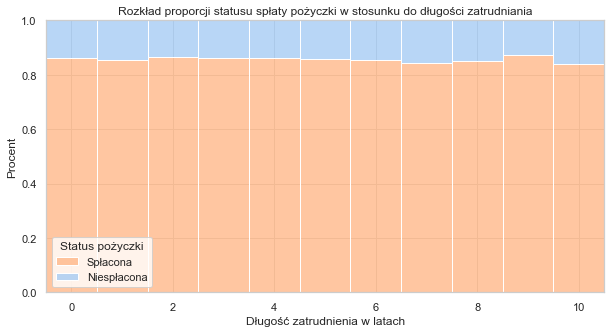

In [81]:
# tutaj zbadam, czy występuje zależność między kolumnami loan_status i emp_length

plt.figure(figsize=(10,5))
sns.histplot(x="emp_length", hue="loan_status", data=df, multiple="fill", discrete=True).set(title="Rozkład proporcji statusu spłaty pożyczki w stosunku do długości zatrudniania", xlabel="Długość zatrudnienia w latach", ylabel="Procent")
plt.legend(labels=["Spłacona", "Niespłacona"], title="Status pożyczki")

# w tym przypadku nie widzimy żadnej większej zależności między okresem zatrudnienia a spłatą pożyczki

W jaki sposób cel pożyczki wiąże się z prawdopodobieństwem niewykonania zobowiązania?

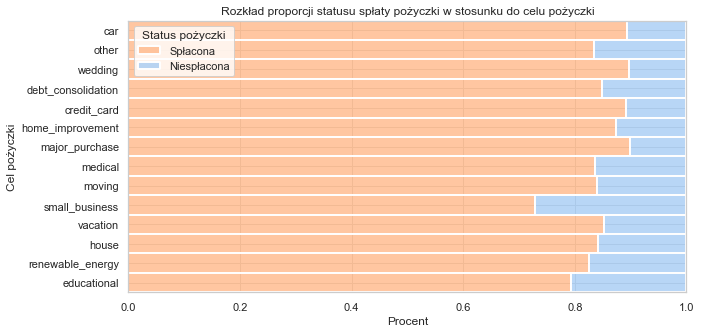

In [82]:
# tutaj zbadam, czy występuje zależność między kolumnami loan_status i purpose

df.purpose.value_counts()

plt.figure(figsize=(10,5))
sns.histplot(y="purpose", hue="loan_status", data=df, multiple="fill", discrete=True).set(title="Rozkład proporcji statusu spłaty pożyczki w stosunku do celu pożyczki", xlabel="Procent", ylabel="Cel pożyczki")
plt.legend(labels=["Spłacona", "Niespłacona"], title="Status pożyczki")

# widzimy, że cel pożyczki wpływa na poziom jej spłacalności, 
# który jest największy przy kredycie na samochód, ślub, większe wydatki i karcie kredytowej,
# a wyrażnie najniższy (bo na poziomie niewiele ponad 70%) przy kredycie dla małych przedsiębiorstw

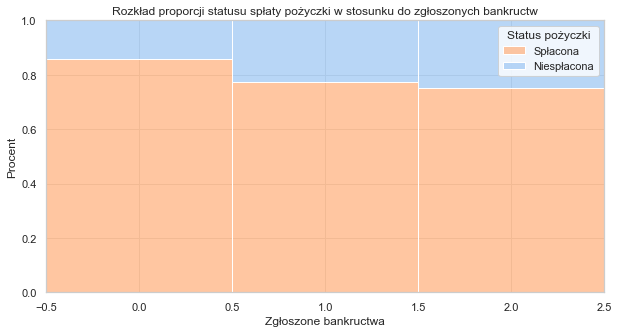

In [83]:
# tutaj zbadam, czy występuje zależność między kolumnami loan_status i pub_rec_bankruptcies

plt.figure(figsize=(10,5))
sns.histplot(x="pub_rec_bankruptcies", hue="loan_status", data=df, multiple="fill", discrete=True).set(title="Rozkład proporcji statusu spłaty pożyczki w stosunku do zgłoszonych bankructw", xlabel="Zgłoszone bankructwa", ylabel="Procent")
plt.legend(labels=["Spłacona", "Niespłacona"], title="Status pożyczki")

### Feature Engineering

W tej części usunę ostatecznie kolumny, które nie będą wykorzystywane przy tworzeniu modeli oraz utworzę nowe kolumny z pomocą metody One-Hot Encoding.

In [84]:
# tworzę nową bazę danych poprzez skopiowanie tej podstawowej

df_new = df
df_new

,loan_amnt,funded_amnt,funded_amnt_inv,term_months,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,pub_rec_bankruptcies,debt_settlement_flag,fico_range
1,2500.0,2500.0,2500.0,60,15.27,59.83,3,C4,0,RENT,30000.0,Source Verified,2011-12,0,car,bike,309,GA,1.00,0,1999-04,5,3,0,1687.0,9.4,4,2016-10,0,0,742.0
3,10000.0,10000.0,10000.0,36,13.49,339.31,3,C1,10,RENT,49200.0,Source Verified,2011-12,1,other,personel,917,CA,20.00,0,1996-02,1,10,0,5598.0,21.0,37,2016-04,0,0,692.0
4,3000.0,3000.0,3000.0,60,12.69,67.79,2,B5,1,RENT,80000.0,Source Verified,2011-12,1,other,Personal,972,OR,17.94,0,1996-01,0,15,0,27783.0,53.9,38,2018-04,0,0,697.0
5,5000.0,5000.0,5000.0,36,7.90,156.46,1,A4,3,RENT,36000.0,Source Verified,2011-12,1,wedding,My wedding loan I promise to pay back,852,AZ,11.20,0,2004-11,3,9,0,7963.0,28.3,12,2017-02,0,0,732.0
6,7000.0,7000.0,7000.0,60,15.96,170.08,3,C5,8,RENT,47004.0,Not Verified,2011-12,1,debt_consolidation,Loan,280,NC,23.51,0,2005-07,1,7,0,17726.0,85.6,11,2016-09,0,0,692.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42443,6000.0,6000.0,1600.0,36,14.70,207.11,5,E5,1,MORTGAGE,22000.0,Not Verified,2007-08,1,debt_consolidation,0 Lates Debt Consolidation. Improve Scre,038,NH,20.00,0,2000-06,19,17,0,15782.0,36.2,17,2018-08,0,0,667.0
42444,1500.0,1500.0,25.0,36,11.86,49.72,4,D1,5,RENT,28000.0,Not Verified,2007-08,1,other,CAR REPAIRS,336,FL,14.31,1,2006-02,1,1,0,0.0,0.0,2,2010-10,0,0,667.0
42446,4500.0,4500.0,3000.0,36,8.07,141.15,1,A4,0,RENT,18240.0,Not Verified,2007-08,1,other,tuirtion and housing,302,GA,3.29,0,2004-04,1,1,0,0.0,0.0,2,2013-10,0,0,737.0
42448,15000.0,15000.0,1000.0,36,12.17,499.45,4,D2,1,MORTGAGE,83200.0,Not Verified,2007-08,1,credit_card,Re-Fi $15K Credit Card,532,WI,17.02,0,1995-10,5,14,0,37570.0,59.5,37,2017-10,0,0,712.0


In [85]:
# usuwam kolumny, których na pewno nie będę wykorzystywał do tworzenia modeli

df_new = df_new.drop(["sub_grade", "issue_d", "title", "zip_code", "addr_state", "earliest_cr_line", "last_credit_pull_d"], axis=1)

In [86]:
# dodaję kolumny z oznaczeniem wysokiego i niskiego wyniku FICO

with pd.option_context("mode.chained_assignment",None):
    df_new["fico_high"] = np.where(df_new["fico_range"]>750, 1, 0)
with pd.option_context("mode.chained_assignment",None):
    df_new["fico_low"] = np.where(df_new["fico_range"]<670, 1, 0)

In [87]:
# wykorzystuję one-hot encoding w kolumnach, w których nie mogę uszeregować wartości malejąco lub rosnąco

df_new = pd.get_dummies(df_new, columns=["home_ownership", "verification_status", "purpose"])
df_new

,loan_amnt,funded_amnt,funded_amnt_inv,term_months,int_rate,installment,grade,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,debt_settlement_flag,fico_range,fico_high,fico_low,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
1,2500.0,2500.0,2500.0,60,15.27,59.83,3,0,30000.0,0,1.00,0,5,3,0,1687.0,9.4,4,0,0,742.0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10000.0,10000.0,10000.0,36,13.49,339.31,3,10,49200.0,1,20.00,0,1,10,0,5598.0,21.0,37,0,0,692.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,3000.0,3000.0,3000.0,60,12.69,67.79,2,1,80000.0,1,17.94,0,0,15,0,27783.0,53.9,38,0,0,697.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,5000.0,5000.0,5000.0,36,7.90,156.46,1,3,36000.0,1,11.20,0,3,9,0,7963.0,28.3,12,0,0,732.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,7000.0,7000.0,7000.0,60,15.96,170.08,3,8,47004.0,1,23.51,0,1,7,0,17726.0,85.6,11,0,0,692.0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42443,6000.0,6000.0,1600.0,36,14.70,207.11,5,1,22000.0,1,20.00,0,19,17,0,15782.0,36.2,17,0,0,667.0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
42444,1500.0,1500.0,25.0,36,11.86,49.72,4,5,28000.0,1,14.31,1,1,1,0,0.0,0.0,2,0,0,667.0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
42446,4500.0,4500.0,3000.0,36,8.07,141.15,1,0,18240.0,1,3.29,0,1,1,0,0.0,0.0,2,0,0,737.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
42448,15000.0,15000.0,1000.0,36,12.17,499.45,4,1,83200.0,1,17.02,0,5,14,0,37570.0,59.5,37,0,0,712.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [88]:
# ustawiam X i Y

X = df_new.drop("loan_status", axis=1)
Y = df_new["loan_status"]

In [89]:
# balansuję zbiór danych za pomocą algorytmu SMOTE, jednocześnie tworząc X_res(ample) i Y_res

print("Oryginalny podział danych:", Counter(Y))
smote = SMOTE()
X_res, Y_res = smote.fit_resample(X, Y)
print("Zmieniony podział danych:", Counter(Y_res))

Oryginalny podział danych: Counter({1: 32964, 0: 5600})
Zmieniony podział danych: Counter({0: 32964, 1: 32964})


In [90]:
# tworzę pełną bazę danych poprzez dodanie "loan_status" do X_res i nazywam to df_res

df_res = X_res
df_res.insert(loc=0, column="loan_status", value=Y_res)


In [91]:
df_res

,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term_months,int_rate,installment,grade,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,debt_settlement_flag,fico_range,fico_high,fico_low,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,0,2500.000000,2500.000000,2500.000000,60,15.270000,59.830000,3,0,30000.000000,1.000000,0,5,3,0,1687.000000,9.400000,4,0,0,742.000000,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,10000.000000,10000.000000,10000.000000,36,13.490000,339.310000,3,10,49200.000000,20.000000,0,1,10,0,5598.000000,21.000000,37,0,0,692.000000,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,3000.000000,3000.000000,3000.000000,60,12.690000,67.790000,2,1,80000.000000,17.940000,0,0,15,0,27783.000000,53.900000,38,0,0,697.000000,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,5000.000000,5000.000000,5000.000000,36,7.900000,156.460000,1,3,36000.000000,11.200000,0,3,9,0,7963.000000,28.300000,12,0,0,732.000000,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,7000.000000,7000.000000,7000.000000,60,15.960000,170.080000,3,8,47004.000000,23.510000,0,1,7,0,17726.000000,85.600000,11,0,0,692.000000,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65923,0,11654.291290,11654.291290,11266.013688,60,15.361369,279.358979,3,7,49913.572822,20.907717,0,1,10,0,18651.822789,64.476567,14,0,0,701.135728,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
65924,0,6909.924208,6909.924208,6885.460373,36,14.013919,236.398584,3,9,49764.087211,21.659277,0,2,7,0,60464.835483,94.102480,21,0,0,677.857865,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
65925,0,24681.676019,16787.460905,16699.659323,52,11.927092,431.542624,2,0,50000.000000,5.478849,0,2,11,0,32738.908702,77.833520,30,0,0,746.549719,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
65926,0,15088.686192,15088.686192,15020.056382,57,17.904124,397.726893,3,10,80586.241003,15.711869,0,2,14,0,12230.027145,46.445876,28,0,0,682.886862,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

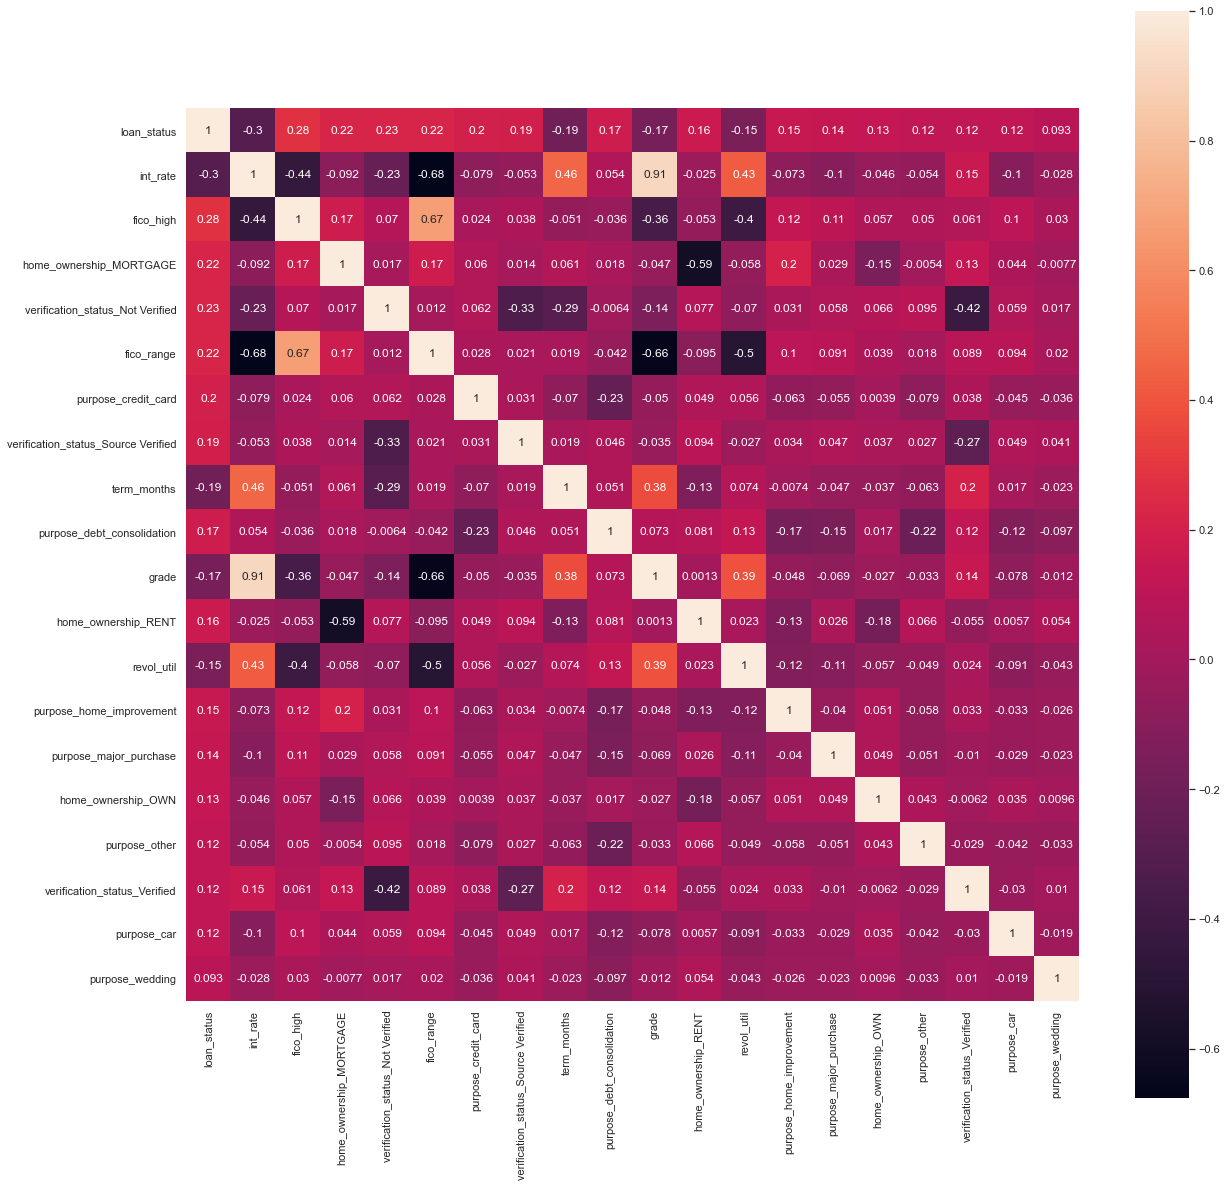

In [92]:
# tworzę macierz korelacji między loan_status a 19 najbardziej skorelowanymi wartościami
# korzystam z funkcji abs(), ponieważ zależy mi na otrzymaniu zarówno pozytywnej jak i negatywnej korelacji

train, test = train_test_split(df_res, test_size = 0.3)

k = 20
cm = df_res.corr()
cols = abs(cm).nlargest(k, "loan_status")["loan_status"].index
corrmatrix = np.corrcoef(train[cols].values.T)

# wyświetlam macierz jako heatmapę
plt.figure(figsize=(20,20))
sns.heatmap(corrmatrix, cbar=True, annot=True, square=True, yticklabels=cols.values, xticklabels=cols.values)

In [93]:
# wyświetlam kolumny z najbardziej skorelowanymi wartościami, żeby łatwiej skopiować wartości

cols

Index(['loan_status', 'int_rate', 'fico_high', 'home_ownership_MORTGAGE',
       'verification_status_Not Verified', 'fico_range', 'purpose_credit_card',
       'verification_status_Source Verified', 'term_months',
       'purpose_debt_consolidation', 'grade', 'home_ownership_RENT',
       'revol_util', 'purpose_home_improvement', 'purpose_major_purchase',
       'home_ownership_OWN', 'purpose_other', 'verification_status_Verified',
       'purpose_car', 'purpose_wedding'],
      dtype='object')

In [189]:
# wybieram 18 kolumn, w ktorych korelacja jest równa lub wyższa 0,12 (bez względu na to, czy korelacja jest ujemna czy dodatnia)
# i te kolumny będą moją bazą do tworzenia modeli

X_res = X_res[['int_rate', 'fico_high', 'home_ownership_MORTGAGE',
       'verification_status_Not Verified', 'fico_range', 'purpose_credit_card',
       'verification_status_Source Verified', 'term_months',
       'purpose_debt_consolidation', 'grade', 'home_ownership_RENT',
       'revol_util', 'purpose_home_improvement', 'purpose_major_purchase',
       'home_ownership_OWN', 'purpose_other', 'verification_status_Verified',
       'purpose_car']]

### Trenowanie modeli

W tej części przeskaluję dane, żeby zwiększyć wydajność modeli. Następnie podzielę zbiór na zbiór treningowy i testowy.
Jeśli chodzi o trenowanie modeli, to przetestuję kilka podstawowych algorytmów klasyfikacji, po czym na ich podstawię będę trenować modele złożone. Stworzę dla nich tabelę z porównaniem wyników AUROC.
Na koniec wykorzystam algorytmy do klasteryzacji.

In [128]:
scale = StandardScaler()
scale.fit(X_res)
scaled_data = scale.transform(X_res)
X_scaled = pd.DataFrame(scaled_data,columns=X_res.columns)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.685260,-0.352485,-0.71494,-0.715061,1.001695,-0.295029,2.169349,1.558247,-0.795774,0.170976,1.210663,-1.607005,-0.218266,-0.184442,-0.215159,-0.271820,-0.585547,6.527111
1,0.172983,-0.352485,-0.71494,-0.715061,-0.532702,-0.295029,2.169349,-0.730364,-0.795774,0.170976,1.210663,-1.173101,-0.218266,-0.184442,-0.215159,3.678912,-0.585547,-0.153207
2,-0.057253,-0.352485,-0.71494,-0.715061,-0.379262,-0.295029,2.169349,1.558247,-0.795774,-0.578799,1.210663,0.057542,-0.218266,-0.184442,-0.215159,3.678912,-0.585547,-0.153207
3,-1.435795,-0.352485,-0.71494,-0.715061,0.694815,-0.295029,2.169349,-0.730364,-0.795774,-1.328574,1.210663,-0.900041,-0.218266,-0.184442,-0.215159,-0.271820,-0.585547,-0.153207
4,0.883839,-0.352485,-0.71494,1.398481,-0.532702,-0.295029,-0.460968,1.558247,1.256639,0.170976,1.210663,1.243297,-0.218266,-0.184442,-0.215159,-0.271820,-0.585547,-0.153207


In [129]:
# dzielę zbiór na dane 

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_res, test_size = 0.3, random_state=8416)

In [131]:
# regresja logistyczna

model_regr = LogisticRegression(solver="liblinear", random_state=8416)
model_regr.fit(X_train, Y_train)

regr_auroc = round(roc_auc_score(Y_test, model_regr.predict(X_test)), 4)

print("AUROC modelu regresji logistycznej:", regr_auroc)

AUROC modelu regresji logistycznej: 0.8572


In [133]:
# drzewo decyzji

model_dtree = DecisionTreeClassifier(criterion="entropy", random_state=8416)
model_dtree.fit(X_train, Y_train)

dtree_auroc = round(roc_auc_score(Y_test, model_dtree.predict(X_test)), 4)

print("AUROC modelu drzewa decyzji:", dtree_auroc)

AUROC modelu drzewa decyzji: 0.8272


In [137]:
# maszyna wektorów nośnych - odnalezienie najlepszych współczynników

svm_param_rs = {"C": [0.1, 1, 10, 100], "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
           "kernel": ["rbf", "sigmoid"]}

model_svm = SVC(random_state=8416)

svm_rs = RandomizedSearchCV(model_svm, svm_param_grid)
rs = svm_rs.fit(X_train,Y_train)
rs.best_params_


{'kernel': 'rbf', 'gamma': 1, 'C': 1}

In [139]:
# maszyna wektorów nośnych

model_svm = SVC(random_state=8416, C=1, gamma=1, kernel="rbf")
model_svm.fit(X_train, Y_train)

svm_auroc = round(roc_auc_score(Y_test, model_svm.predict(X_test)), 4)

print("AUROC modelu maszyny wektorów nośnych:", svm_auroc)

AUROC modelu maszyny wektorów nośnych: 0.8627


In [140]:
# K najbliższych sąsiadów

model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, Y_train) 

knn_auroc = round(roc_auc_score(Y_test, model_knn.predict(X_test)), 4)

print("AUROC modelu K najbliższych sąsiadów:", knn_auroc)

AUROC modelu K najbliższych sąsiadów: 0.8507


In [149]:
# las drzew decyzyjnych

model_rf = RandomForestClassifier(criterion="entropy", random_state=8416)
model_rf.fit(X_train, Y_train)

rf_auroc = round(roc_auc_score(Y_test, model_rf.predict(X_test)), 4)

print("AUROC modelu lasu drzew decyzyjnych:", rf_auroc)

AUROC modelu lasu drzew decyzyjnych: 0.8756


In [154]:
# bagging

model_bagg = BaggingClassifier(base_estimator=SVC(random_state=8416, C=1, gamma=1, kernel="rbf"), random_state=8416)
model_bagg.fit(X_train, Y_train)

bagg_auroc = round(roc_auc_score(Y_test, model_bagg.predict(X_test)), 4)

print("AUROC modelu maszyny wektorów nośnych z baggingiem:", bagg_auroc)

AUROC modelu maszyny wektorów nośnych z baggingiem: 0.8607


In [155]:
# Ada Boost

model_ada = AdaBoostClassifier(random_state=8416)
model_ada.fit(X_train, Y_train)

ada_auroc = round(roc_auc_score(Y_test, model_ada.predict(X_test)), 4)

print("AUROC modelu AdaBoost:", ada_auroc)

AUROC modelu maszyny wektorów nośnych z AdaBoost: 0.869


In [163]:
# Gradient Boost

model_gbc = GradientBoostingClassifier(learning_rate=0.3, n_estimators=500, random_state=8416)
model_gbc.fit(X_train, Y_train)

gbc_auroc = round(roc_auc_score(Y_test, model_gbc.predict(X_test)), 4)

print("AUROC modelu GradientBoost:", gbc_auroc)

AUROC modelu GradientBoost: 0.9031


In [180]:
# XGBoost

model_xgb = xgb.XGBClassifier(learning_rate=0.3, random_state=8416, use_label_encoder=False)
model_xgb.fit(X_train, Y_train)

xgb_auroc = round(roc_auc_score(Y_test, model_xgb.predict(X_test)), 4)

print("AUROC modelu XGBoost:", xgb_auroc)

[19:52:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUROC modelu XGBoost: 0.9044


In [175]:
# Light GBM

train_data=lgb.Dataset(X_train, label=Y_train)
model_lgb = lgb.train({'learning_rate':0.001}, train_data, 100)

lgb_auroc = round(roc_auc_score(Y_test, model_gbc.predict(X_test)), 4)

print("AUROC modelu GradientBoost:", lgb_auroc)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 835
[LightGBM] [Info] Number of data points in the train set: 46149, number of used features: 18
[LightGBM] [Info] Start training from score 0.499079
AUROC modelu GradientBoost: 0.9031


In [188]:
# tabela porównująca wyniki AUROC wszystkich modeli,
# w której widzimy, że najlepsze były XGBoost, Light GBM i Gradient Boost z wynikiem 90%

wynik = pd.DataFrame.from_dict({"Nazwa algorytmu":["Regresja logistyczna", "Drzewo decyzji", "Maszyna wektorów nośnych", 
                                                   "K najbliższych sąsiadów", "Las drzew decyzyjnych", "Bagging", 
                                                   "Ada Boost", "Gradient Boost", "XGBoost", "Light GBM"],
                               "AUROC":[regr_auroc, dtree_auroc, svm_auroc, knn_auroc, rf_auroc, bagg_auroc, 
                                        ada_auroc, gbc_auroc, xgb_auroc, lgb_auroc]})
wynik

,Nazwa algorytmu,AUROC
0,Regresja logistyczna,0.8572
1,Drzewo decyzji,0.8272
2,Maszyna wektorów nośnych,0.8627
3,K najbliższych sąsiadów,0.8507
4,Las drzew decyzyjnych,0.8756
5,Bagging,0.8607
6,Ada Boost,0.8690
7,Gradient Boost,0.9031
8,XGBoost,0.9044
9,Light GBM,0.9031


Teraz przechodzę do stworzenia modeli uczenia nienadzorowanego.

In [198]:
# z df_new tworzę podzbiór danych, na którym będę testował klasteryzację

df_new_cluster = df_new.sample(frac=0.2, replace=False)
df_new_cluster

,loan_amnt,funded_amnt,funded_amnt_inv,term_months,int_rate,installment,grade,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,debt_settlement_flag,fico_range,fico_high,fico_low,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
15943,10000.0,10000.0,9921.010462,36,9.99,322.63,2,10,69000.00,1,16.26,0,2,4,0,18578.0,72.3,13,0,0,757.0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
23110,25000.0,25000.0,21756.998628,60,20.77,673.11,7,10,132000.00,1,13.42,4,0,7,0,33637.0,77.0,24,0,0,667.0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
24951,15000.0,15000.0,15000.000000,36,13.61,509.83,3,4,111147.66,1,13.10,0,0,14,0,10461.0,59.8,20,0,0,697.0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
41626,4800.0,4800.0,502.087645,36,13.55,163.01,4,1,36400.00,1,4.65,1,1,4,0,4684.0,80.8,9,0,0,652.0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4691,10000.0,10000.0,10000.000000,36,10.65,325.74,2,4,45000.00,1,14.69,0,0,6,0,5272.0,65.9,18,0,0,707.0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27482,25000.0,25000.0,23940.324409,36,11.86,828.69,2,9,53196.00,1,16.94,0,0,4,0,10269.0,61.9,16,0,0,742.0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
34704,6000.0,6000.0,6000.000000,36,12.53,200.80,2,1,52000.00,1,21.72,0,0,7,0,4742.0,36.8,23,0,0,692.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
26290,18000.0,18000.0,17975.000000,60,13.23,411.68,3,5,143004.00,1,7.41,0,0,5,0,0.0,0.0,25,0,0,742.0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
13346,9000.0,9000.0,8950.000000,36,7.49,279.92,1,5,96000.00,1,10.35,0,0,9,0,13543.0,32.1,20,0,0,737.0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [200]:
# skaluję dane

scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(df_new_cluster)

# zmieniam skalowane dane na DataFrame
df_cluster = pd.DataFrame(X_cluster,columns=df_new_cluster.columns)

In [201]:
df_cluster

,loan_amnt,funded_amnt,funded_amnt_inv,term_months,int_rate,installment,grade,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,debt_settlement_flag,fico_range,fico_high,fico_low,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,-0.157620,-0.125348,-0.041127,-0.601863,-0.590861,-0.002940,-0.465294,1.431673,0.023744,0.413452,0.424159,-0.301195,0.618173,-1.211341,-0.238321,0.323964,0.830485,-0.816577,-0.210763,-0.05927,1.186771,2.117044,-0.312947,1.111016,-0.062488,-0.267206,-0.964458,-0.873713,1.740626,-0.684327,-0.202908,-0.391484,1.063326,-0.103661,-0.284088,-0.10681,-0.240582,-0.127826,-0.126774,-0.33947,-0.045593,-0.193727,-0.088544,-0.162319
1,1.889312,1.997270,1.648646,1.661507,2.339613,1.711656,3.032577,1.431673,1.366101,0.413452,0.000623,7.241397,-0.741578,-0.515344,-0.238321,1.246670,0.998254,0.234965,-0.210763,-0.05927,-1.339240,-0.472357,3.195427,-0.900077,-0.062488,-0.267206,1.036851,-0.873713,-0.574506,1.461289,-0.202908,-0.391484,1.063326,-0.103661,-0.284088,-0.10681,-0.240582,-0.127826,-0.126774,-0.33947,-0.045593,-0.193727,-0.088544,-0.162319
2,0.524691,0.582192,0.683978,-0.601863,0.393213,0.912868,0.234280,-0.256007,0.921795,0.413452,-0.047099,-0.301195,-0.741578,1.108652,-0.238321,-0.173386,0.384291,-0.147414,-0.210763,-0.05927,-0.497237,-0.472357,-0.312947,1.111016,-0.062488,-0.267206,-0.964458,-0.873713,1.740626,-0.684327,-0.202908,-0.391484,1.063326,-0.103661,-0.284088,-0.10681,-0.240582,-0.127826,-0.126774,-0.33947,-0.045593,-0.193727,-0.088544,-0.162319
3,-0.867223,-0.861189,-1.385827,-0.601863,0.376902,-0.783823,0.933854,-1.099848,-0.670873,0.413452,-1.307267,1.584453,-0.061703,-1.211341,-0.238321,-0.527358,1.133897,-1.198956,-0.210763,-0.05927,-1.760242,-0.472357,3.195427,-0.900077,-0.062488,-0.267206,1.036851,1.144541,-0.574506,-0.684327,-0.202908,2.554384,-0.940445,-0.103661,-0.284088,-0.10681,-0.240582,-0.127826,-0.126774,-0.33947,-0.045593,-0.193727,-0.088544,-0.162319
4,-0.157620,-0.125348,-0.029850,-0.601863,-0.411445,0.012274,-0.465294,-0.256007,-0.487630,0.413452,0.190021,-0.301195,-0.741578,-0.747343,-0.238321,-0.491330,0.602034,-0.338604,-0.210763,-0.05927,-0.216569,-0.472357,-0.312947,1.111016,-0.062488,-0.267206,-0.964458,1.144541,-0.574506,-0.684327,-0.202908,-0.391484,-0.940445,-0.103661,3.520032,-0.10681,-0.240582,-0.127826,-0.126774,-0.33947,-0.045593,-0.193727,-0.088544,-0.162319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7708,1.889312,1.997270,1.960350,-0.601863,-0.082514,2.472774,-0.465294,1.150393,-0.312996,0.413452,0.525569,-0.301195,-0.741578,-1.211341,-0.238321,-0.185150,0.459252,-0.529793,-0.210763,-0.05927,0.765769,-0.472357,-0.312947,-0.900077,-0.062488,-0.267206,1.036851,-0.873713,-0.574506,1.461289,-0.202908,-0.391484,1.063326,-0.103661,-0.284088,-0.10681,-0.240582,-0.127826,-0.126774,-0.33947,-0.045593,-0.193727,-0.088544,-0.162319
7709,-0.703468,-0.691379,-0.600913,-0.601863,0.099621,-0.598950,-0.465294,-1.099848,-0.338479,0.413452,1.238421,-0.301195,-0.741578,-0.515344,-0.238321,-0.523805,-0.436705,0.139370,-0.210763,-0.05927,-0.637571,-0.472357,-0.312947,-0.900077,-0.062488,-0.267206,1.036851,1.144541,-0.574506,-0.684327,-0.202908,-0.391484,-0.940445,-0.103661,-0.284088,-0.10681,4.156591,-0.127826,-0.126774,-0.33947,-0.045593,-0.193727,-0.088544,-0.162319
7710,0.934077,1.006715,1.108706,1.661507,0.289912,0.432704,0.234280,0.025273,1.600566,0.413452,-0.895662,-0.

In [212]:
# wykorzystuję algorytm PCA do zmniejszenia wymiarów

pca_df = PCA(random_state=8416)
pca_df.fit(df_cluster)

PCA(random_state=8416)

In [214]:
# sprawdzam zsumowaną wariancję

var_cumu = np.cumsum(pca_df.explained_variance_ratio_)
var_cumu

array([0.12408869, 0.21440829, 0.26596061, 0.30928532, 0.34836478,
       0.38267518, 0.41478903, 0.4452625 , 0.47334084, 0.49984376,
       0.52586156, 0.55089384, 0.57571318, 0.59974279, 0.62328555,
       0.64667613, 0.6700012 , 0.69316172, 0.71614839, 0.73898782,
       0.76168573, 0.78416361, 0.80626405, 0.82801579, 0.8489262 ,
       0.86845445, 0.88760584, 0.90543715, 0.9226691 , 0.93972414,
       0.95459355, 0.9650852 , 0.97479292, 0.98289997, 0.98884609,
       0.99385845, 0.99621467, 0.99812971, 0.99917821, 0.99982266,
       1.        , 1.        , 1.        , 1.        ])

In [219]:
# widzimy po zsumowanej wariancji, że poziom 95% otrzymujemy po zsumowaniu 31 kolumn,
# więc na tyle ustawiam n_components przy tworzeniu nowego pca_df

pca_df = PCA(random_state=8416, n_components=31)
pca_final = pca_df.fit_transform(df_cluster)

In [220]:
# jeszcze raz się upewniam, jak wygląda suma wariancji

var_cumu2 = np.cumsum(pca_df.explained_variance_ratio_)
var_cumu2

array([0.12408869, 0.21440829, 0.26596061, 0.30928532, 0.34836478,
       0.38267518, 0.41478903, 0.4452625 , 0.47334084, 0.49984376,
       0.52586156, 0.55089384, 0.57571318, 0.59974279, 0.62328555,
       0.64667613, 0.6700012 , 0.69316172, 0.71614839, 0.73898782,
       0.76168573, 0.78416361, 0.80626405, 0.82801579, 0.8489262 ,
       0.86845445, 0.88760584, 0.90543715, 0.9226691 , 0.93972414,
       0.95459355])

<AxesSubplot:>

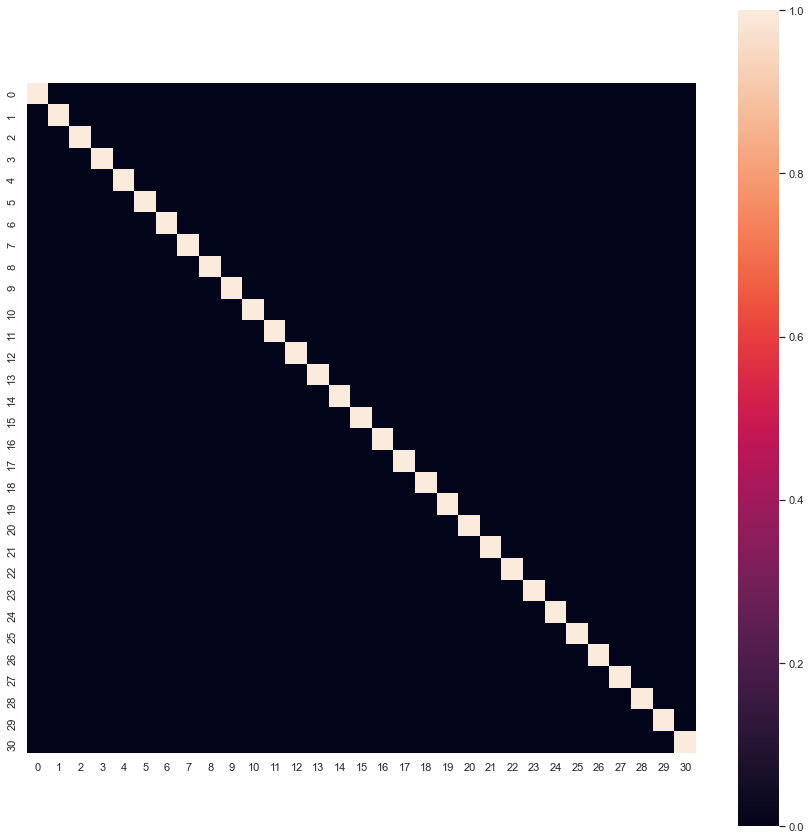

In [224]:
# na przygotowanym wykresie możemy potwierdzić, że nowe kolumny nie są ze sobą skorelowane

corrmat = np.corrcoef(pca_final.transpose())
corrmat.shape
plt.figure(figsize=[15,15])
sns.heatmap(corrmat, square=True)

In [235]:
# przygotowuję algorytm KMean, ale żeby go dobrze przygotować muszę wyznaczyć liczbę klastrów
# do tego celu wykorzystuję miarę wewnętrzną

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000, random_state=8416)
    kmeans.fit(pca_final)
    
    cluster_labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(pca_final, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.1039511018291499
For n_clusters=3, the silhouette score is 0.08475637700966265
For n_clusters=4, the silhouette score is 0.09570863544344962
For n_clusters=5, the silhouette score is 0.052813066583522236
For n_clusters=6, the silhouette score is 0.08589695697084637
For n_clusters=7, the silhouette score is 0.08999257527310559
For n_clusters=8, the silhouette score is 0.09723643528601916


In [243]:
# możemy zobaczyć, że najskuteczniejsze jest podzielenie na 2 klastry, chociaż nie ma ono bardzo wysokiego wyniku
# co może oznaczać, że w tym przypadku klasteryzacja dla tego zbioru tym algorytmem może nie być najlepszym rozwiązaniem,
# ale w takim razie sprawdzę inne algorytmy

kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=8416)
kmeans.fit(pca_final)

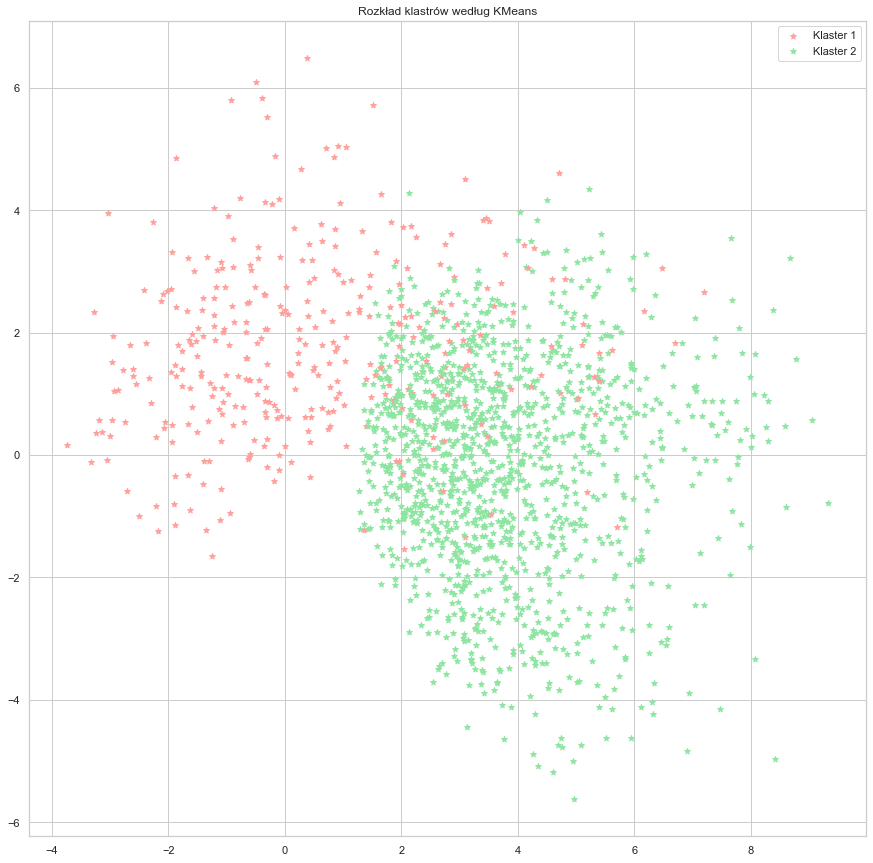

In [266]:
# rysuję wykres rozkłady klastrów według KMeans

plt.figure(figsize=(15,15))
for i in range(0, pca_final.shape[0]):
    if kmeans.labels_[i] == 0:
        c1 = plt.scatter(pca_final[i,0],pca_final[i,1],c="r", marker='*')
    elif kmeans.labels_[i] == 1:
        c2 = plt.scatter(pca_final[i,0],pca_final[i,1],c="g", marker='*')
plt.legend([c1, c2], ["Klaster 1", "Klaster 2"])
plt.title("Rozkład klastrów według KMeans")
plt.show()

In [277]:
# sprawdzam algorytm DBSCAN

db_scan = DBSCAN(eps=15, min_samples=10)
db_scan.fit(pca_final)

DBSCAN(eps=15, min_samples=10)

In [273]:
# liczba klastrów i szumów

n_clusters_ = len(set(db_scan.labels_))-(1 if -1 in db_scan.labels_ else 0)
n_noise_ = list(db_scan.labels_).count(-1)

print("Liczba klastrów", n_clusters_)
print("Liczba niepasujących punktów", n_noise_)


Liczba klastrów 4
Liczba niepasujących punktów 0


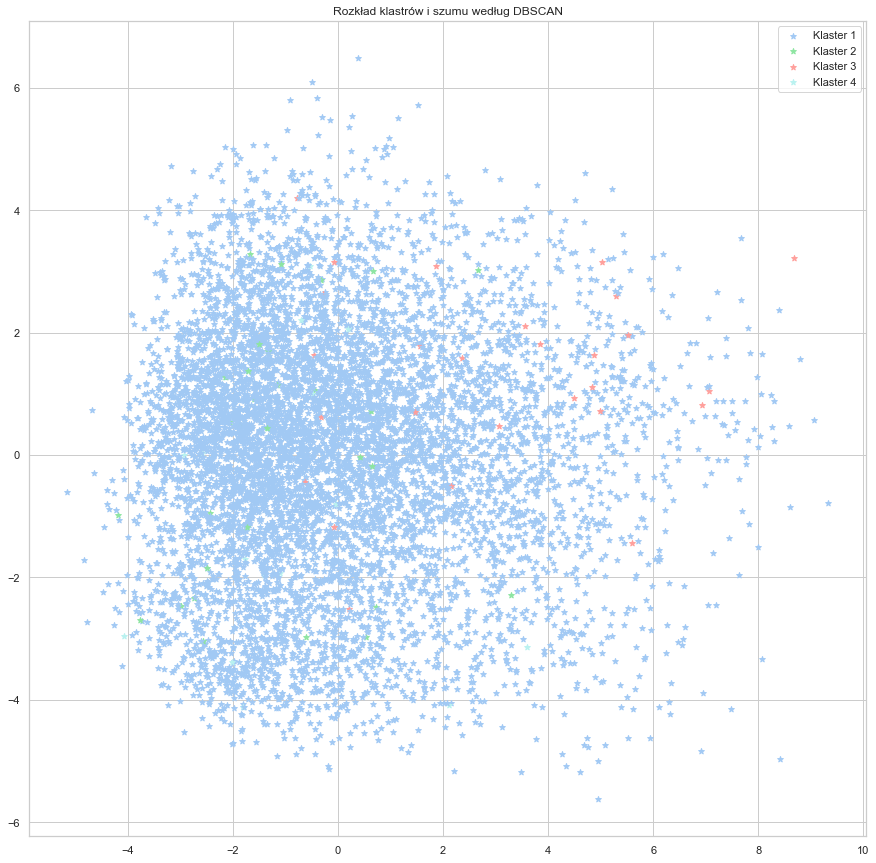

In [274]:
# rysuję wykres rozkłady klastrów według DBSCAN

plt.figure(figsize=(15,15))
for i in range(0, pca_final.shape[0]):
    if db_scan.labels_[i] == 0:
        c1 = plt.scatter(pca_final[i,0],pca_final[i,1],c="b", marker="*")
    elif db_scan.labels_[i] == 1:
        c2 = plt.scatter(pca_final[i,0],pca_final[i,1],c="g", marker="*")
    elif db_scan.labels_[i] == 2:
        c3 = plt.scatter(pca_final[i,0],pca_final[i,1],c="r", marker="*")
    elif db_scan.labels_[i] == 3:
        c4 = plt.scatter(pca_final[i,0],pca_final[i,1],c="c", marker="*")
plt.legend([c1, c2, c3, c4], ["Klaster 1", "Klaster 2", "Klaster 3", "Klaster 4"])
plt.title("Rozkład klastrów i szumu według DBSCAN")
plt.show()

In [278]:
# testuję jeszcze jeden algorytm do klasteryzacji, czyli SpectralClustering

spectral = SpectralClustering(n_clusters=2, random_state=8416)
spectral.fit(pca_final)

SpectralClustering(n_clusters=2, random_state=8416)

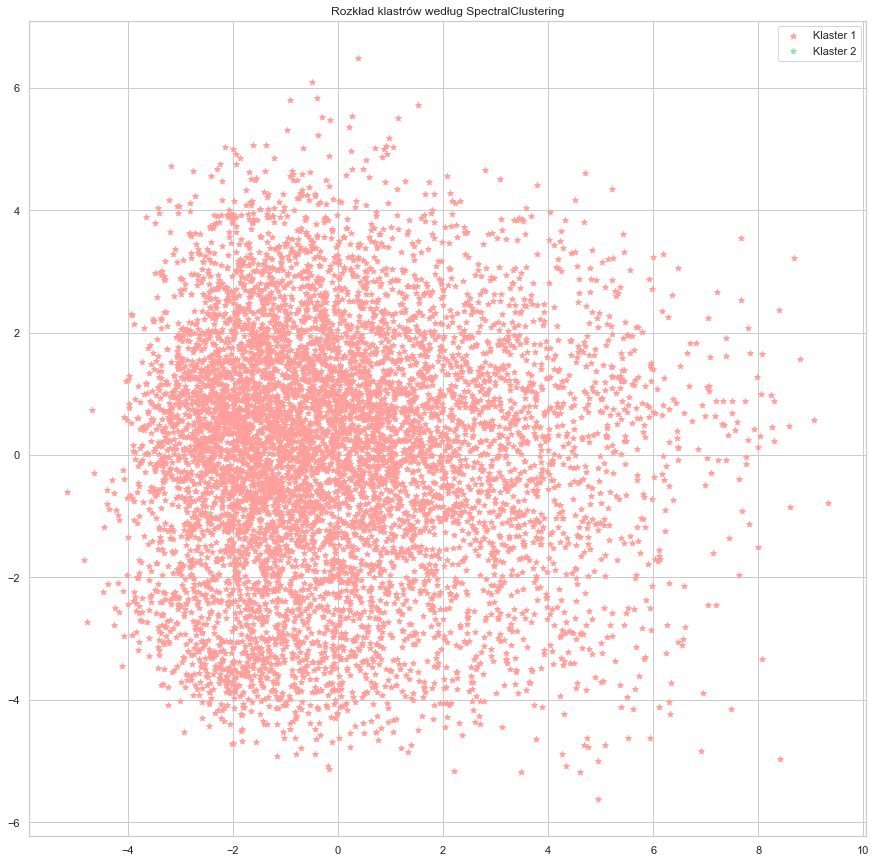

In [279]:
# i również dla niego tworzę wykres

plt.figure(figsize=(15,15))
for i in range(0, pca_final.shape[0]):
    if spectral.labels_[i] == 0:
        c1 = plt.scatter(pca_final[i,0],pca_final[i,1],c="r", marker='*')
    elif spectral.labels_[i] == 1:
        c2 = plt.scatter(pca_final[i,0],pca_final[i,1],c="g", marker='*')
plt.legend([c1, c2], ["Klaster 1", "Klaster 2"])
plt.title("Rozkład klastrów według SpectralClustering")
plt.show()

W przypadku tego zbioru, głównie ze względu na ogromną liczbę zmiennych, znacznie lepiej poradziły sobie algorytmy do klasyfikacji niż te do klasteryzacji - w szczególności, że mamy do czynienia z danymi o z góry wiadomym efekcie, czyli że ktoś nie spłacił lub spłacił kredyt.